In [1]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xf dakshina_dataset_v1.0.tar

--2025-05-20 09:13:58--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 142.251.188.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   263MB/s    in 7.6s    

2025-05-20 09:14:06 (251 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [ ]:
!rm -r dakshina_dataset_v1.0

In [2]:
!ls

dakshina_dataset_v1.0  dakshina_dataset_v1.0.tar


In [53]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Attention Mechanism
# -------------------------------
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, src_mask):
        src_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(src_mask == 0, -1e10)
        return torch.softmax(attention, dim=1)

# -------------------------------
# Dataset and Vocabulary
# -------------------------------
class TransliterationDataset(Dataset):
    def __init__(self, data, source_vocab=None, target_vocab=None):
        # Clean data: remove NaN entries and convert to strings
        self.data = data.dropna(subset=['latin', 'devanagari'])
        self.data['latin'] = self.data['latin'].astype(str)
        self.data['devanagari'] = self.data['devanagari'].astype(str)
        
        # Build vocabularies
        self.source_vocab = source_vocab or self.build_vocab(self.data['latin'])
        self.target_vocab = target_vocab or self.build_vocab(self.data['devanagari'], add_sos_eos=True)
        self.inv_target_vocab = {v: k for k, v in self.target_vocab.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x = str(row['latin']).strip()
        y = str(row['devanagari']).strip()
        x_idx = [self.source_vocab.get(char, self.source_vocab['<unk>']) for char in x]
        y_idx = [self.target_vocab['<sos>']] + \
                [self.target_vocab.get(char, self.target_vocab['<unk>']) for char in y] + \
                [self.target_vocab['<eos>']]
        return torch.tensor(x_idx), torch.tensor(y_idx)

    def build_vocab(self, sequences, add_sos_eos=False):
        valid_seqs = [str(seq) for seq in sequences if pd.notna(seq) and str(seq).strip()]
        chars = set()
        for seq in valid_seqs:
            for char in seq.strip():
                chars.add(char)
        vocab = {'<pad>': 0, '<unk>': 1}
        for idx, char in enumerate(sorted(chars)):
            vocab[char] = idx + 2  # Start from index 2
        if add_sos_eos:
            vocab['<sos>'] = len(vocab)
            vocab['<eos>'] = len(vocab)
        return vocab

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_padded = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_padded, tgt_padded

# -------------------------------
# Encoder
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, cell_type, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        rnn_class = getattr(nn, cell_type)
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, 
                           batch_first=True, 
                           dropout=dropout if num_layers > 1 else 0.0)

    def forward(self, src, src_lens):
        embedded = self.embedding(src)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lens, 
                                                 batch_first=True, 
                                                 enforce_sorted=False)
        packed_output, hidden = self.rnn(packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        return output, hidden

# -------------------------------
# Decoder with Attention Tracking
# -------------------------------
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, cell_type, dropout=0.0, attention=None):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        rnn_class = getattr(nn, cell_type)
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers,
                           batch_first=True, 
                           dropout=dropout if num_layers > 1 else 0.0)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = attention
        self.attention_weights = []

    def forward(self, input_char, hidden, encoder_outputs, src_mask):
        embedded = self.embedding(input_char.unsqueeze(1))
        h = hidden[0][-1] if isinstance(hidden, tuple) else hidden[-1]
        attn_weights = self.attention(h, encoder_outputs, src_mask)
        if not self.training:
            self.attention_weights.append(attn_weights.detach().cpu())
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        prediction = self.fc_out(torch.cat(
            (output.squeeze(1), context.squeeze(1)), dim=1
        ))
        return prediction, hidden

    def reset_attention(self):
        self.attention_weights = []

# -------------------------------
# Seq2Seq Model with Visualization Support
# -------------------------------
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def create_mask(self, seq):
        return (seq != 0).float()

    def forward(self, src, tgt=None, teacher_forcing_ratio=0.5, return_attention=False, max_length=50):
        # Handle inference case (no tgt provided)
        if tgt is None:
            return self.infer(src, max_length, return_attention)

        # Original training logic
        batch_size, tgt_len = tgt.shape
        tgt_vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(src.device)
        
        if return_attention:
            self.decoder.reset_attention()
        
        src_lens = torch.count_nonzero(src, dim=1).cpu()
        encoder_outputs, hidden = self.encoder(src, src_lens)
        src_mask = self.create_mask(src)
        
        input_char = tgt[:, 0]
        for t in range(1, tgt_len):
            output, hidden = self.decoder(input_char, hidden, encoder_outputs, src_mask)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input_char = tgt[:, t] if random.random() < teacher_forcing_ratio else top1
        
        if return_attention:
            attn_weights = torch.stack(self.decoder.attention_weights, dim=1)
            return outputs, attn_weights
        return outputs


    def infer(self, src, max_length=50, return_attention=False):
        """Fixed inference method with dimension handling"""
        # Ensure input is 2D (batch, seq_len)
        if src.dim() == 1:
            src = src.unsqueeze(0)  # Add batch dimension
        
        batch_size = src.size(0)
        tgt_vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(batch_size, max_length, tgt_vocab_size).to(src.device)
        
        if return_attention:
            self.decoder.reset_attention()
        
        src_lens = (src != 0).sum(dim=1).cpu()  # Now safe with 2D input
        encoder_outputs, hidden = self.encoder(src, src_lens)
        src_mask = self.create_mask(src)
        
        input_char = torch.full((batch_size,), 
                              self.decoder.embedding.padding_idx + 1,  # <sos>
                              device=src.device)
        
        for t in range(max_length):
            output, hidden = self.decoder(input_char, hidden, encoder_outputs, src_mask)
            outputs[:, t] = output
            input_char = output.argmax(1)
        
        if return_attention:
            attn_weights = torch.stack(self.decoder.attention_weights, dim=1)
            return outputs, attn_weights
        return outputs


# -------------------------------
# Accuracy Calculation
# -------------------------------

def calculate_word_accuracy(model, dataloader, device):
    """
    Computes word-level (exact match) accuracy for your seq2seq model.
    Only counts as correct if the entire predicted word matches the target word,
    ignoring <pad>, <sos>, and <eos> tokens.
    """
    model.eval()
    total_correct = 0
    total_words = 0

    # Get special token indices from the dataset's target vocab
    vocab = dataloader.dataset.target_vocab
    pad_idx = vocab['<pad>']
    sos_idx = vocab['<sos>']
    eos_idx = vocab['<eos>']

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            outputs = model(src, tgt)  # (batch, seq_len, vocab_size)
            preds = outputs.argmax(-1) # (batch, seq_len)
            for pred_seq, tgt_seq in zip(preds, tgt):
                # Remove special tokens from both sequences
                pred_tokens = [p.item() for p in pred_seq
                               if p.item() not in {pad_idx, sos_idx, eos_idx}]
                tgt_tokens = [t.item() for t in tgt_seq
                              if t.item() not in {pad_idx, sos_idx, eos_idx}]
                if pred_tokens == tgt_tokens:
                    total_correct += 1
                total_words += 1
    return total_correct / total_words if total_words > 0 else 0.0


# -------------------------------
# Training Loop with Validation
# -------------------------------
def train_model(config):
    # Load training and validation data
    base_path = f'dakshina_dataset_v1.0/{config.lang_code}/lexicons'
    df_train = pd.read_csv(
        f"{base_path}/{config.lang_code}.translit.sampled.train.tsv",
        sep='\t',
        names=['devanagari', 'latin', 'people'],
        usecols=['devanagari', 'latin'],
        dtype={'devanagari': str, 'latin': str}
    ).dropna().reset_index(drop=True)
    df_val = pd.read_csv(
        f"{base_path}/{config.lang_code}.translit.sampled.dev.tsv",
        sep='\t',
        names=['devanagari', 'latin', 'people'],
        usecols=['devanagari', 'latin'],
        dtype={'devanagari': str, 'latin': str}
    ).dropna().reset_index(drop=True)
    df_test = pd.read_csv(
        f"{base_path}/{config.lang_code}.translit.sampled.test.tsv",
        sep='\t',
        names=['devanagari', 'latin', 'people'],
        usecols=['devanagari', 'latin'],
        dtype={'devanagari': str, 'latin': str}
    ).dropna().reset_index(drop=True)

    train_dataset = TransliterationDataset(df_train)
    val_dataset = TransliterationDataset(df_val, train_dataset.source_vocab, train_dataset.target_vocab)
    test_dataset = TransliterationDataset(df_test, train_dataset.source_vocab, train_dataset.target_vocab)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                            shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                          shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size,
                          shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)

    # Model initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    attention = Attention(config.hidden_dim)
    encoder = Encoder(len(train_dataset.source_vocab), config.embed_dim, 
                    config.hidden_dim, config.num_layers, config.cell_type)
    decoder = Decoder(len(train_dataset.target_vocab), config.embed_dim,
                    config.hidden_dim, config.num_layers, config.cell_type, 
                    attention=attention)
    model = Seq2Seq(encoder, decoder).to(device)

    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    best_val_acc = 0.0

    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            outputs = model(src, tgt)
            loss = criterion(outputs[:, 1:].reshape(-1, outputs.shape[-1]),
                             tgt[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
       
        train_acc = calculate_accuracy(model, train_loader, device)
        val_acc = calculate_accuracy(model, val_loader, device)
        test_acc = calculate_accuracy(model, test_loader, device)
        wandb.log({"epoch": epoch, "loss": total_loss / len(train_loader), "val_accuracy": val_acc , "test_accuracy":test_acc,"train_accuracy":train_acc , "val_loss":total_loss / len(train_loader)})
        print(f"Epoch {epoch+1}/{config.epochs} | Loss: {total_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% Test Acc: {test_acc*100:.2f}%")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    print(f'Best Validation Accuracy: {best_val_acc*100:.2f}%')
    return model, train_dataset, val_dataset, device


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch

def pad_tensor_2d(attn, max_tgt, max_src):
    # attn: (tgt_len, src_len)
    tgt_len, src_len = attn.size()
    pad_tgt = max_tgt - tgt_len
    pad_src = max_src - src_len
    pad = (0, pad_src, 0, pad_tgt)
    return torch.nn.functional.pad(attn, pad, "constant", 0)

def get_predictions(model, dataset, dataloader, device, max_length=50):
    model.eval()
    all_attention = []
    all_predictions = []
    all_inputs = []
    
    source_vocab_inv = {v: k for k, v in dataset.source_vocab.items()}
    target_vocab_inv = {v: k for k, v in dataset.target_vocab.items()}
    sos_idx = dataset.target_vocab['<sos>']
    eos_idx = dataset.target_vocab['<eos>']
    pad_idx = dataset.target_vocab['<pad>']

    # First pass: collect all attention shapes
    max_tgt_len = 0
    max_src_len = 0
    attn_maps_per_sample = []
    pred_per_sample = []
    input_per_sample = []

    with torch.no_grad():
        for src_batch, _ in dataloader:
            src_batch = src_batch.to(device)
            if src_batch.dim() == 1:
                src_batch = src_batch.unsqueeze(0)
            batch_size = src_batch.size(0)
            src_lens = (src_batch != pad_idx).sum(dim=1).cpu()
            encoder_outputs, hidden = model.encoder(src_batch, src_lens)
            src_mask = model.create_mask(src_batch)
            
            input_char = torch.full((batch_size,), sos_idx, dtype=torch.long, device=device)
            outputs = []
            attn_weights = []
            model.decoder.reset_attention()
            
            ended = torch.zeros(batch_size, dtype=torch.bool, device=device)
            for step in range(max_length):
                output, hidden = model.decoder(input_char, hidden, encoder_outputs, src_mask)
                top1 = output.argmax(1)
                outputs.append(top1)
                attn_weights.append(model.decoder.attention_weights[-1])
                input_char = top1
                ended = ended | (top1 == eos_idx)
                if ended.all():
                    break
            
            outputs = torch.stack(outputs, dim=1)  # (batch, tgt_len)
            attn_weights = torch.stack(attn_weights, dim=1)  # (batch, tgt_len, src_len)
            
            for i in range(batch_size):
                attn_map = attn_weights[i][:, :encoder_outputs.size(1)]
                tgt_len, src_len = attn_map.size()
                max_tgt_len = max(max_tgt_len, tgt_len)
                max_src_len = max(max_src_len, src_len)
                attn_maps_per_sample.append(attn_map.cpu())
                
                pred_ids = outputs[i].tolist()
                pred_str = []
                for idx in pred_ids:
                    if idx == eos_idx:
                        break
                    if idx in (sos_idx, pad_idx):
                        continue
                    pred_str.append(target_vocab_inv.get(idx, '?'))
                pred_per_sample.append(''.join(pred_str))
                
                input_ids = src_batch[i][src_batch[i] != pad_idx].tolist()
                input_str = ''.join([source_vocab_inv.get(idx, '?') for idx in input_ids])
                input_per_sample.append(input_str)

    # Now pad all attention maps to (max_tgt_len, max_src_len)
    all_attention = [pad_tensor_2d(attn, max_tgt_len, max_src_len) for attn in attn_maps_per_sample]
    all_attention = torch.stack(all_attention, dim=0)
    return all_attention, pred_per_sample, input_per_sample




In [59]:
# Download the font (direct raw link)
!wget -O /root/.fonts/NotoSansDevanagari-Regular.ttf "https://github.com/googlefonts/noto-fonts/blob/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf?raw=true"


--2025-05-20 11:03:33--  https://github.com/googlefonts/noto-fonts/blob/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/notofonts/noto-fonts/blob/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf?raw=true [following]
--2025-05-20 11:03:33--  https://github.com/notofonts/noto-fonts/blob/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/notofonts/noto-fonts/raw/refs/heads/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf [following]
--2025-05-20 11:03:33--  https://github.com/notofonts/noto-fonts/raw/refs/heads/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.tt

In [61]:
import matplotlib.font_manager as fm
import os

# Make sure the directory exists
os.makedirs('/root/.fonts', exist_ok=True)

# Register the font with matplotlib
font_files = fm.findSystemFonts(fontpaths=['/root/.fonts'])
for font_file in font_files:
    fm.fontManager.addfont(font_file)


In [62]:
import matplotlib as mpl
import os

# Find the cache directory
cache_dir = mpl.get_cachedir()
print("Matplotlib cache dir:", cache_dir)

# Remove the font cache file(s)
for fname in ["fontlist-v330.json", "fontlist-v340.json", "fontlist-v350.json", "fontlist-v360.json", "fontlist-v370.json", "fontlist-v380.json"]:
    fpath = os.path.join(cache_dir, fname)
    if os.path.exists(fpath):
        os.remove(fpath)


Matplotlib cache dir: /root/.cache/matplotlib


In [63]:
import os
os.path.exists(os.path.expanduser('~/.fonts/NotoSansDevanagari-Regular.ttf'))


True

In [65]:
import matplotlib.font_manager as fm
fm._load_fontmanager(try_read_cache=False)  # Force reload


In [66]:
import matplotlib.font_manager as fm
font_names = [f.name for f in fm.fontManager.ttflist]
print(sorted(set(font_names)))


['C059', 'D050000L', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif Display', 'Droid Sans Fallback', 'Humor Sans', 'Liberation Mono', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Serif', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans Narrow', 'Noto Mono', 'Noto Sans Devanagari', 'Noto Sans Mono', 'P052', 'STIXGeneral', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeFourSym', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'Standard Symbols PS', 'URW Bookman', 'URW Gothic', 'Z003', 'cmb10', 'cmex10', 'cmmi10', 'cmr10', 'cmss10', 'cmsy10', 'cmtt10']


In [67]:
import matplotlib.font_manager
for f in matplotlib.font_manager.fontManager.ttflist:
    if 'Noto Sans Devanagari' in f.name:
        print(f.name)

Noto Sans Devanagari
Noto Sans Devanagari


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import io
from PIL import Image
import wandb
# Use Devanagari for Hindi, and fallback to DejaVu Sans for English
plt.rcParams['font.family'] = ['Noto Sans Devanagari', 'DejaVu Sans']

def plot_attention_grid(attention_weights, input_words, output_words, num_plots=10,example=0):
    """
    Plots attention heatmaps for up to 10 examples in a 3x4 grid.
    Each heatmap uses only the true (unpadded) input and output lengths.
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    n = min(num_plots, len(attention_weights), len(input_words), len(output_words))
    for i in range(n):
        attn = attention_weights[i]
        inp = input_words[i]
        out = output_words[i]
        # Only plot up to the true lengths
        attn_plot = attn[:len(out), :len(inp)].numpy()
        sns.heatmap(attn_plot, 
                    annot=False, 
                    xticklabels=list(inp),
                    yticklabels=list(out),
                    ax=axes[i],
                    cbar=False)
        axes[i].set_title(f"Ex {i+1}: {inp} → {out}")
        axes[i].set_xlabel("Input Chars")
        axes[i].set_ylabel("Output Chars")
        # Rotate x labels for clarity
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    # Hide unused subplots
    for j in range(n, 12):
        axes[j].axis('off')
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    pil_img = Image.open(buf)
    wandb.log({"example":example,"attention grid": wandb.Image(pil_img)})
    buf.close()
    plt.show()


In [50]:
def predict_single(model, src_idx, dataset, device, max_len=50):
    """Greedy decode using attention-based decoder"""
    model.eval()
    with torch.no_grad():
        src_tensor = torch.tensor(src_idx, dtype=torch.long).unsqueeze(0).to(device)
        src_lens = [len(src_idx)]
        
        # Fixed encoder call
        encoder_outputs, hidden = model.encoder(
            src_tensor, 
            torch.tensor(src_lens, dtype=torch.long).cpu()
        )
        
        # Fixed mask creation
        src_mask = model.create_mask(src_tensor)
        
        input_char = torch.tensor([dataset.target_vocab['<sos>']], device=device)
        output_idxs = []

        for _ in range(max_len):
            logits, hidden = model.decoder(input_char, hidden, encoder_outputs, src_mask)
            top1 = logits.argmax(1).item()

            if top1 == dataset.target_vocab['<eos>']:
                break

            output_idxs.append(top1)
            input_char = torch.tensor([top1], device=device)

    return output_idxs

def log_test_predictions(model, dataset, test_loader, device, n_samples=20):
    """Logs test predictions with dimension handling"""
    import wandb
    table = wandb.Table(columns=["Word", "Translation", "Prediction", "Correct"])
    
    source_vocab_inv = {v: k for k, v in dataset.source_vocab.items()}
    inv_target_vocab = {v: k for k, v in dataset.target_vocab.items()}
    
    collected = 0
    for batch in test_loader:
        # Handle different batch formats
        if len(batch) == 2:
            src_batch, tgt_batch = batch
        else:
            src_batch, tgt_batch = batch, batch
            
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        
        # Fixed length calculation
        def safe_sum(tensor):
            if tensor.dim() == 1:  # Handle 1D tensors
                return [int((tensor != 0).sum().item())]
            return (tensor != 0).sum(dim=1).tolist()
            
        src_lens = safe_sum(src_batch)
        tgt_lens = safe_sum(tgt_batch)

        for i in range(len(src_lens)):
            if collected >= n_samples:
                break
                
            # Get actual sequence lengths
            src_len = src_lens[i]
            tgt_len = tgt_lens[i]
            
            # Handle 1D vs 2D tensors
            if src_batch.dim() == 2:
                latin_idxs = src_batch[i, :src_len].tolist()
                tgt_seq = tgt_batch[i, 1:tgt_len-1].tolist()  # Exclude SOS/EOS
            else:  # 1D tensor
                latin_idxs = src_batch[:src_len].tolist()
                tgt_seq = tgt_batch[1:tgt_len-1].tolist()
            
            # Convert to strings
            latin_str = ''.join([source_vocab_inv.get(idx, '?') for idx in latin_idxs])
            true_str = ''.join([inv_target_vocab.get(idx, '?') for idx in tgt_seq])
            
            # Prediction
            pred_idxs = predict_single(model, latin_idxs, dataset, device)
            pred_str = ''.join([inv_target_vocab.get(idx, '?') for idx in pred_idxs])
            
            table.add_data(latin_str, true_str, pred_str, "Yes" if pred_str == true_str else "No")
            collected += 1

    wandb.log({"Test Predictions with attention" : table})
    return table



In [55]:
# best model config
class Config:
    def __init__(self,
                 embed_dim=64,
                 hidden_dim=256,
                 num_layers=3,
                 cell_type="LSTM",
                 dropout=0.3,
                 lr=0.0005,
                 batch_size=32,
                 lang_code="hi",
                 epochs=10):          # note 'epochs' not 'epoch'
        self.embed_dim   = embed_dim
        self.hidden_dim  = hidden_dim
        self.num_layers  = num_layers
        self.cell_type   = cell_type
        self.dropout     = dropout
        self.lr          = lr
        self.batch_size  = batch_size
        self.lang_code   = lang_code
        self.epochs      = epochs

config = Config()

# wandb.login(key="2b8654ea1d7143307fd59d1ea1bda5bc9f6fef77")
wandb.init(project="da6401_assignment_3", entity="cs24m048-iit-madras")
model , dataset , test_loader , device = train_model(config)
# best_table = log_test_predictions(model, dataset, test_loader, device, n_samples=len(test_loader))

Epoch 1/10: 100%|██████████| 1382/1382 [01:09<00:00, 19.82it/s]


Epoch 1/10 | Loss: 1.6434 | Train Acc: 41.67% | Val Acc: 41.10% Test Acc: 41.39%


Epoch 2/10: 100%|██████████| 1382/1382 [01:09<00:00, 20.01it/s]


Epoch 2/10 | Loss: 0.8141 | Train Acc: 48.97% | Val Acc: 45.60% Test Acc: 45.75%


Epoch 3/10: 100%|██████████| 1382/1382 [01:08<00:00, 20.21it/s]


Epoch 3/10 | Loss: 0.6489 | Train Acc: 53.07% | Val Acc: 48.46% Test Acc: 47.46%


Epoch 4/10: 100%|██████████| 1382/1382 [01:08<00:00, 20.15it/s]


Epoch 4/10 | Loss: 0.5516 | Train Acc: 56.20% | Val Acc: 49.98% Test Acc: 49.46%


Epoch 5/10: 100%|██████████| 1382/1382 [01:08<00:00, 20.08it/s]


Epoch 5/10 | Loss: 0.4721 | Train Acc: 58.49% | Val Acc: 49.82% Test Acc: 49.92%


Epoch 6/10: 100%|██████████| 1382/1382 [01:08<00:00, 20.11it/s]


Epoch 6/10 | Loss: 0.4013 | Train Acc: 60.20% | Val Acc: 50.34% Test Acc: 50.24%


Epoch 7/10: 100%|██████████| 1382/1382 [01:08<00:00, 20.20it/s]


Epoch 7/10 | Loss: 0.3415 | Train Acc: 61.86% | Val Acc: 50.36% Test Acc: 50.34%


Epoch 8/10: 100%|██████████| 1382/1382 [01:09<00:00, 19.98it/s]


Epoch 8/10 | Loss: 0.2929 | Train Acc: 63.47% | Val Acc: 51.64% Test Acc: 49.87%


Epoch 9/10: 100%|██████████| 1382/1382 [01:08<00:00, 20.07it/s]


Epoch 9/10 | Loss: 0.2464 | Train Acc: 64.11% | Val Acc: 50.82% Test Acc: 50.67%


Epoch 10/10: 100%|██████████| 1382/1382 [01:09<00:00, 19.95it/s]


Epoch 10/10 | Loss: 0.2159 | Train Acc: 65.38% | Val Acc: 50.42% Test Acc: 50.81%
Best Validation Accuracy: 51.64%


In [56]:
 best_table = log_test_predictions(model, dataset, test_loader, device, n_samples=len(test_loader))

In [54]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁▅▆▇▇███▇█
train_accuracy,▁▃▄▅▆▇▇▇██
val_accuracy,▁▅▆▇▇███▇█
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,9
loss,0.21151
test_accuracy,0.80406
train_accuracy,0.95312
val_accuracy,0.80683


In [ ]:
best_table = log_test_predictions(model, dataset, test_loader, device, n_samples=len(test_loader))

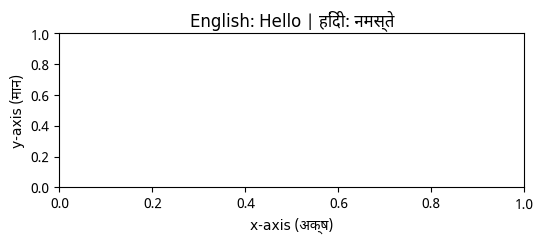

In [16]:
import matplotlib.pyplot as plt

# Use Devanagari for Hindi, and fallback to DejaVu Sans for English
plt.rcParams['font.family'] = ['Noto Sans Devanagari', 'DejaVu Sans']

plt.figure(figsize=(6,2))
plt.title("English: Hello | हिंदी: नमस्ते")
plt.xlabel("x-axis (अक्ष)")
plt.ylabel("y-axis (मान)")
plt.show()


In [69]:
# Get predictions and attention weights
# Example: (replace with your actual model class and args)

attention_weights, predictions, inputs = get_predictions(model, dataset ,test_loader, device)




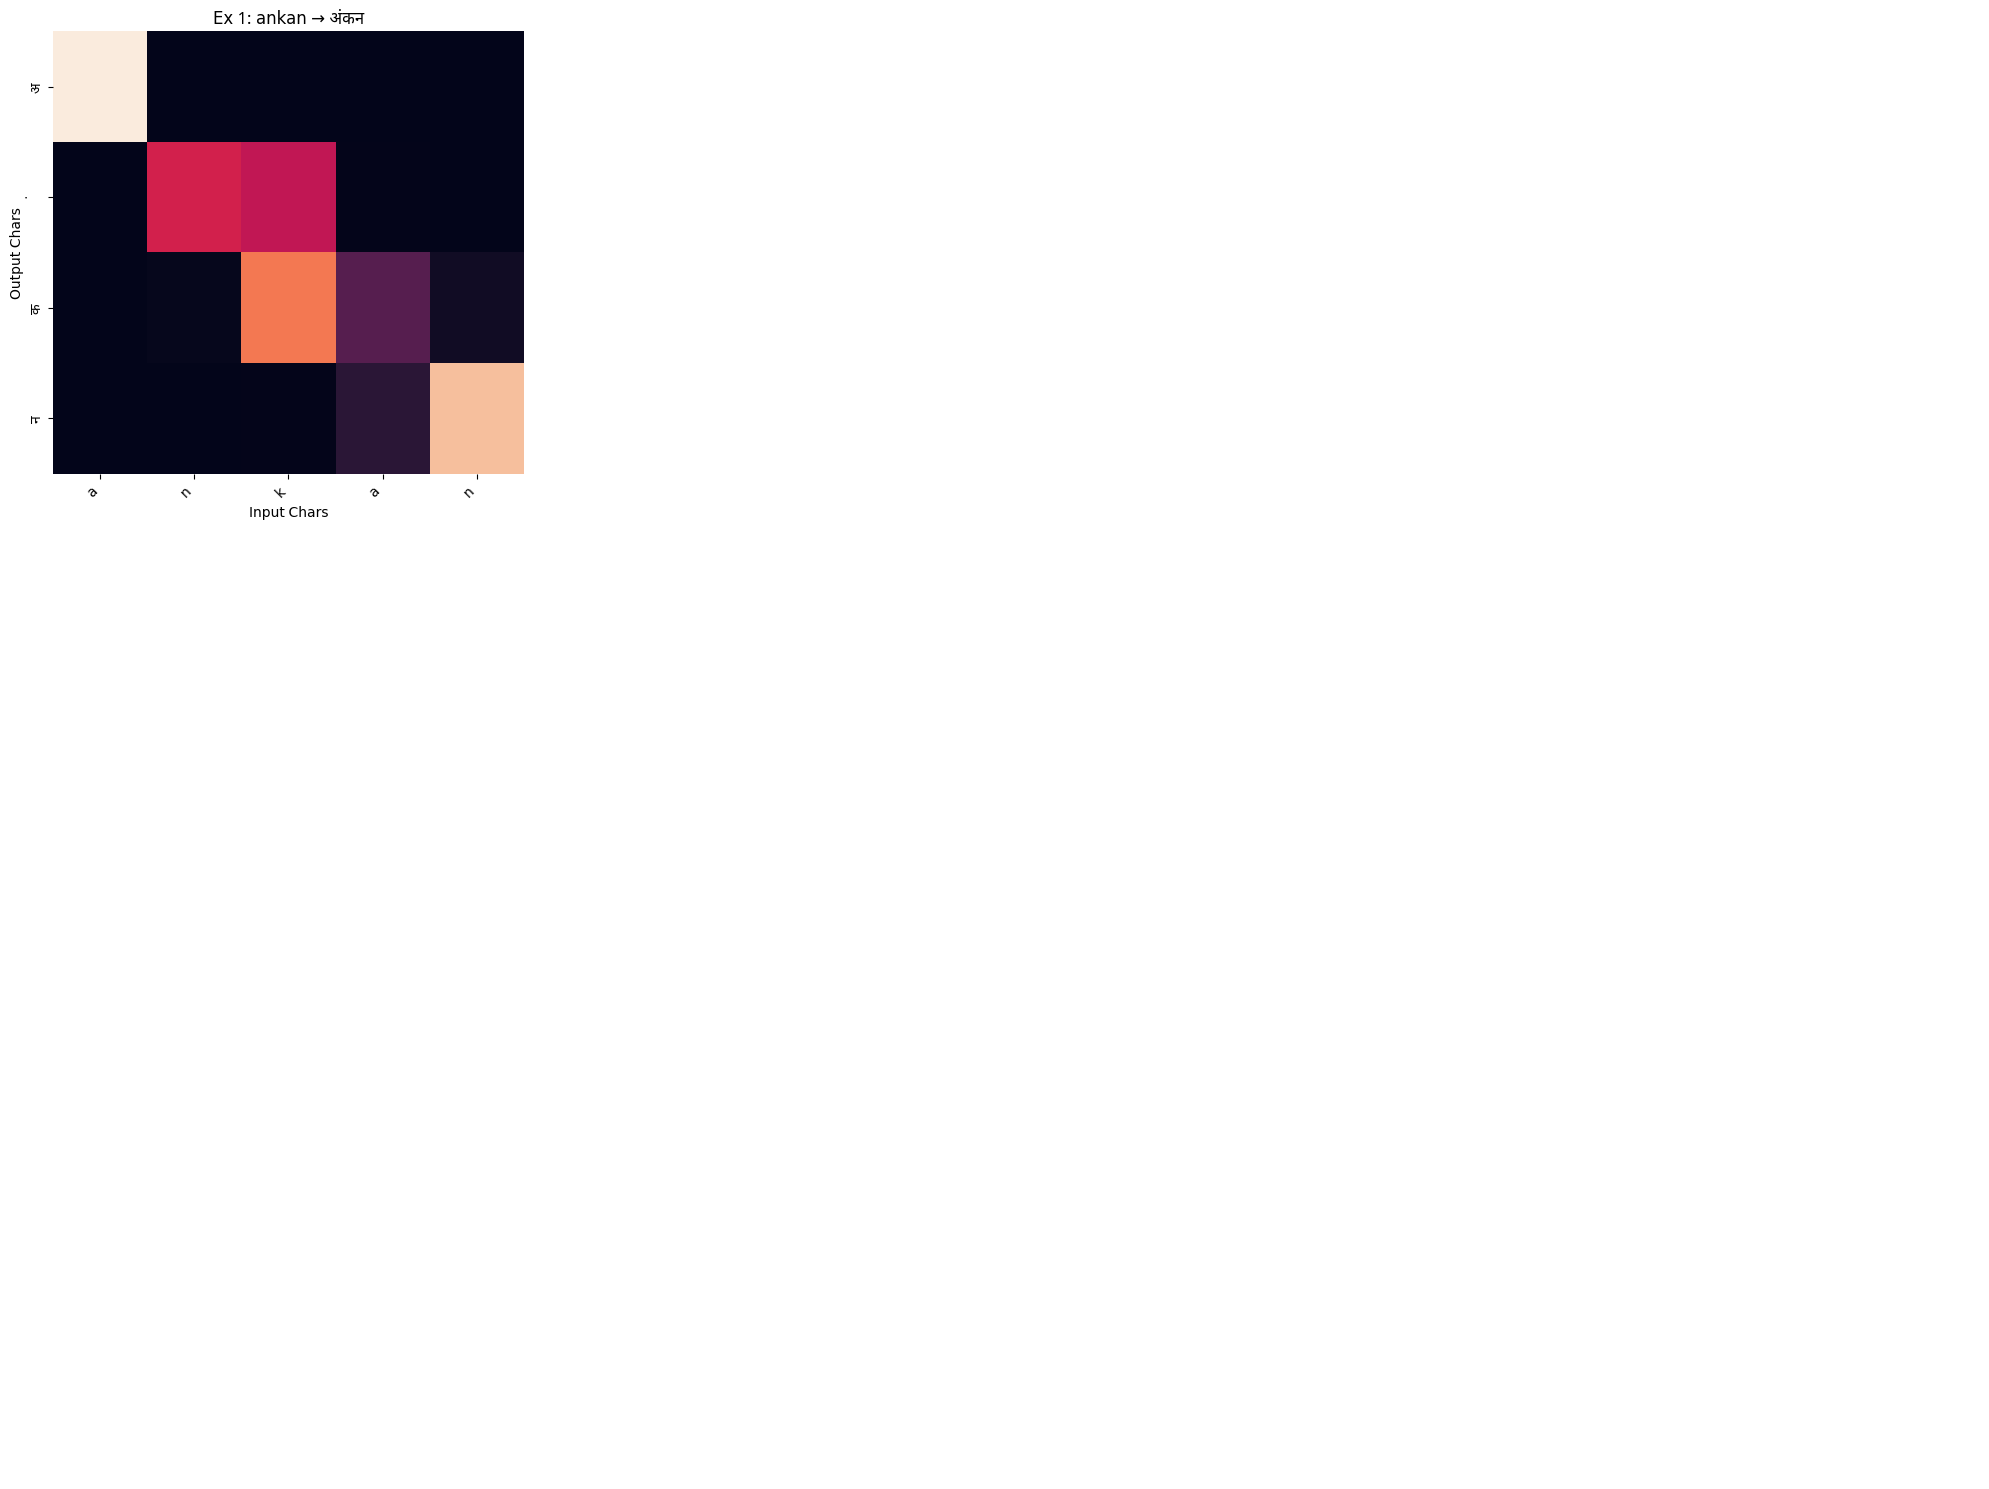

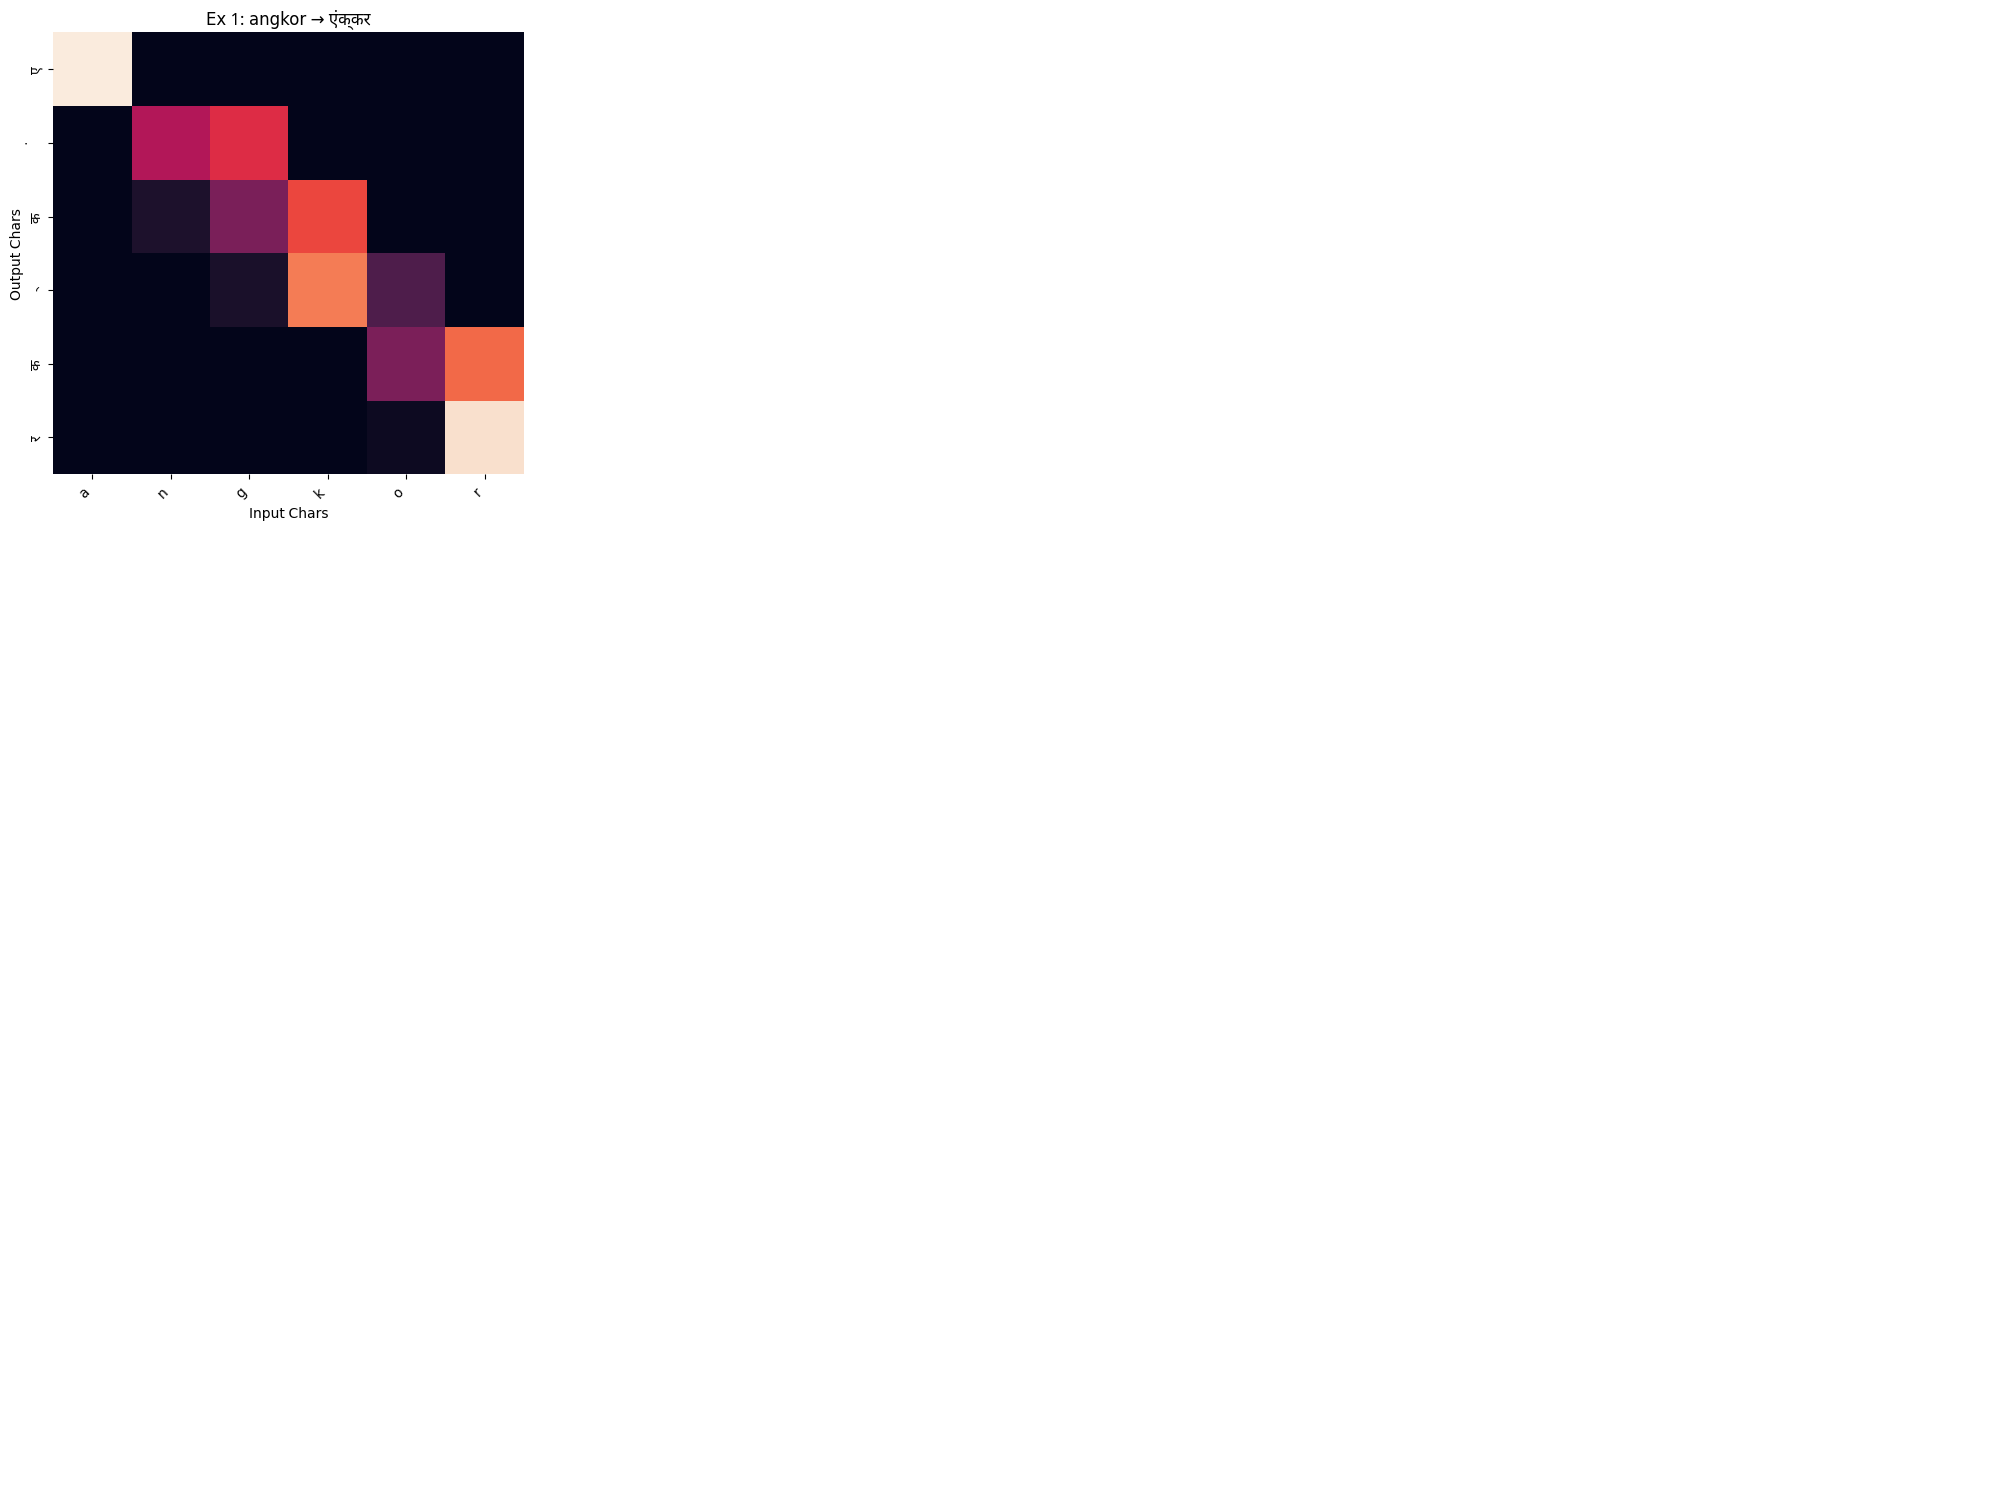

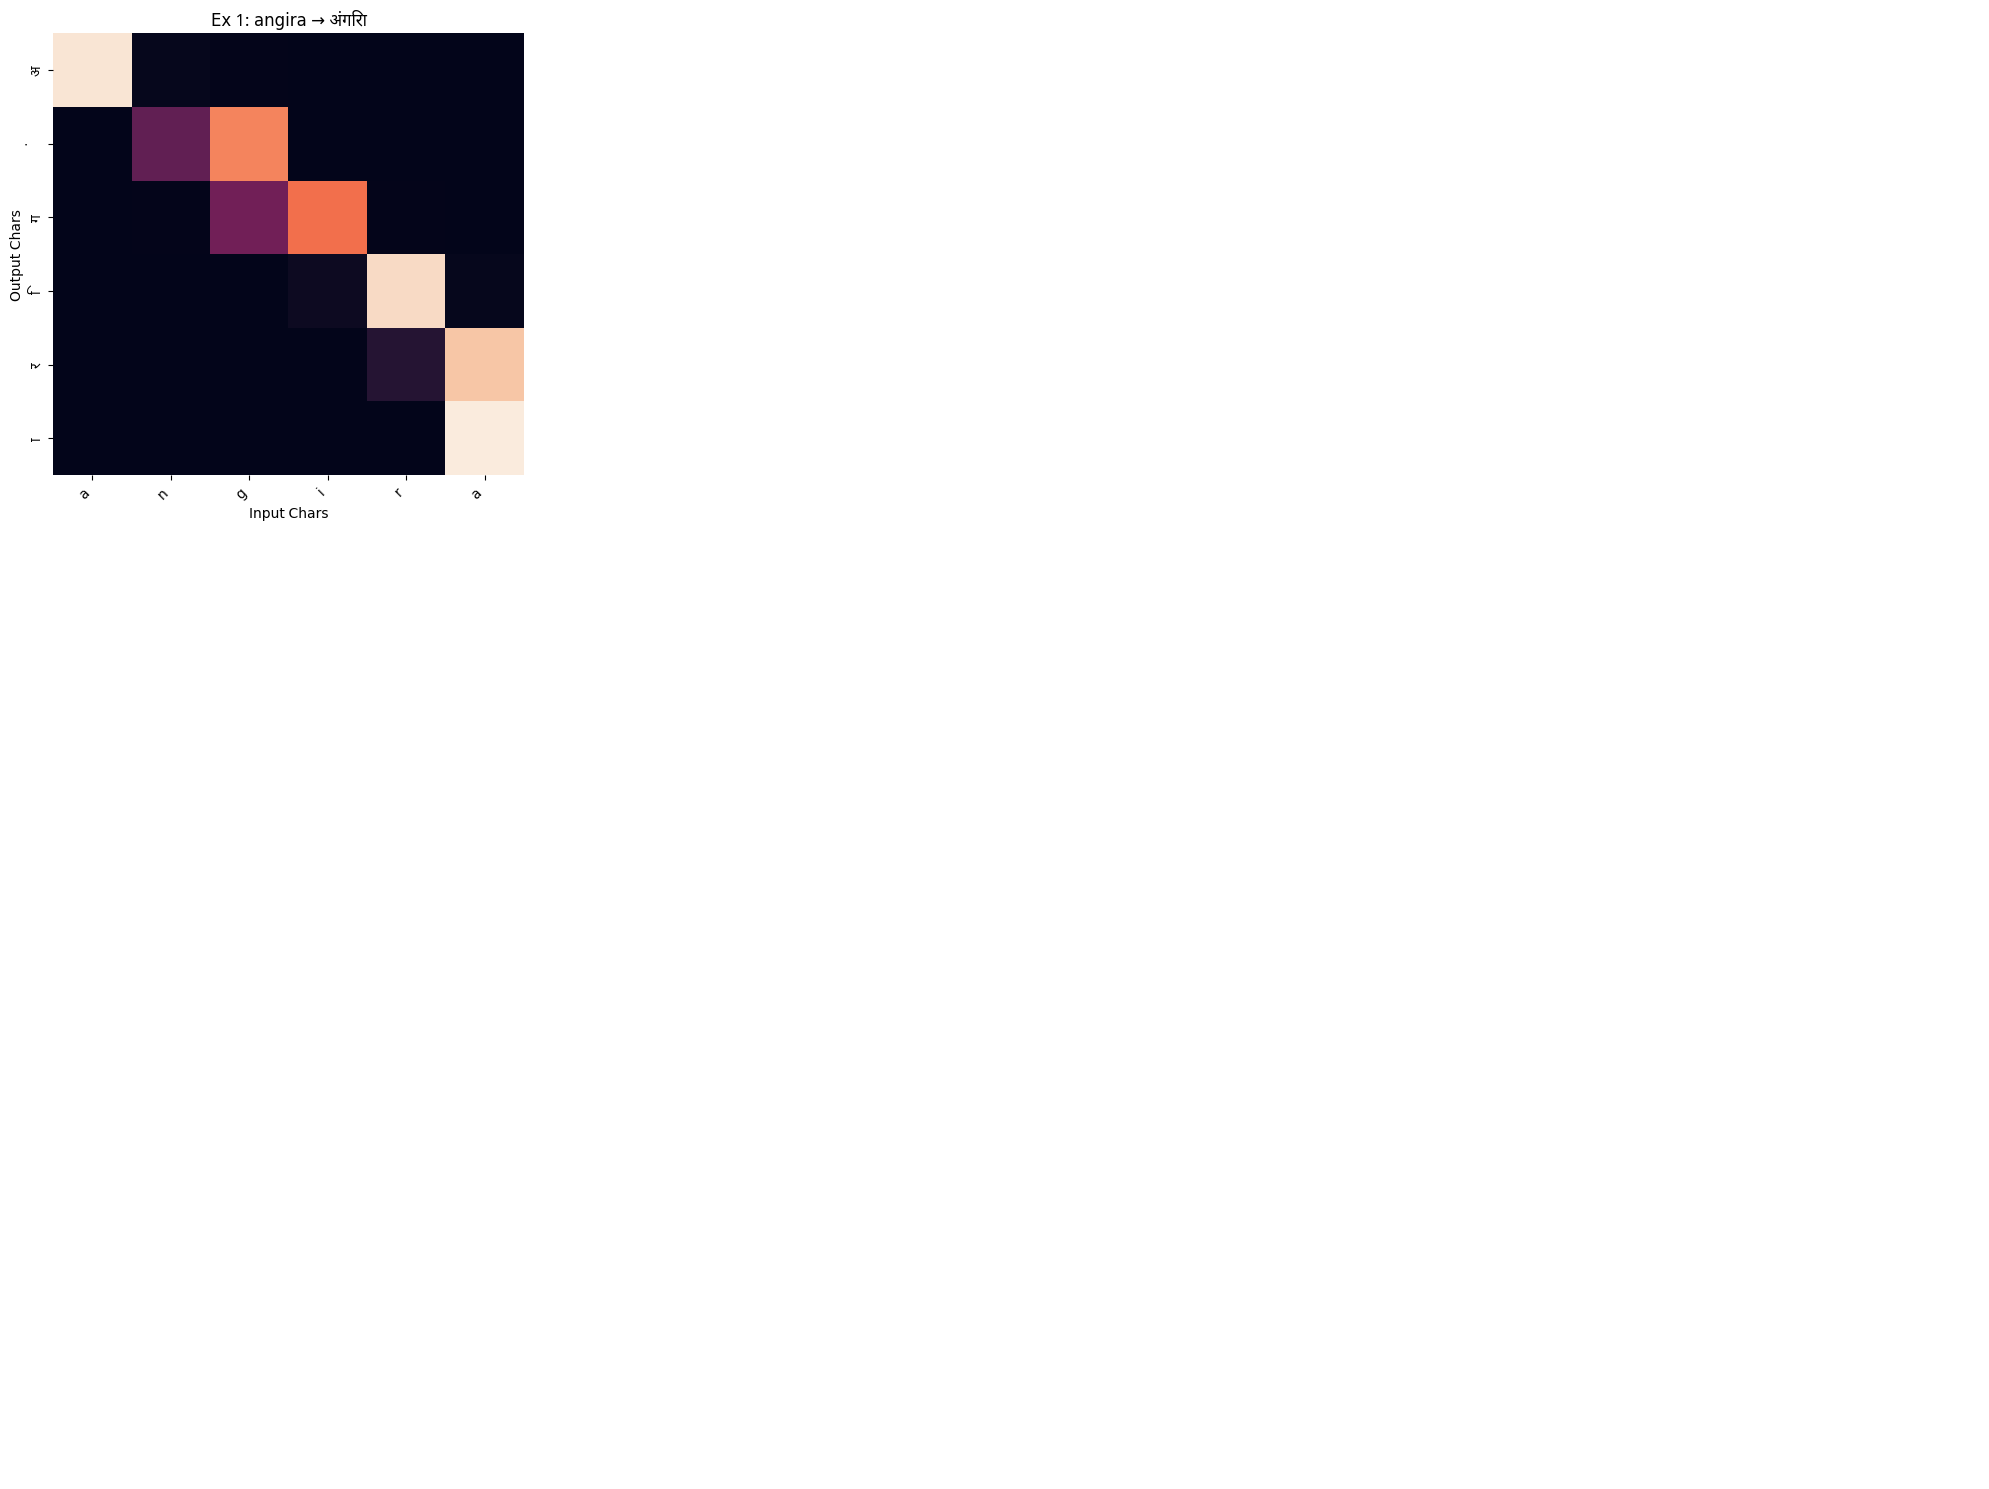

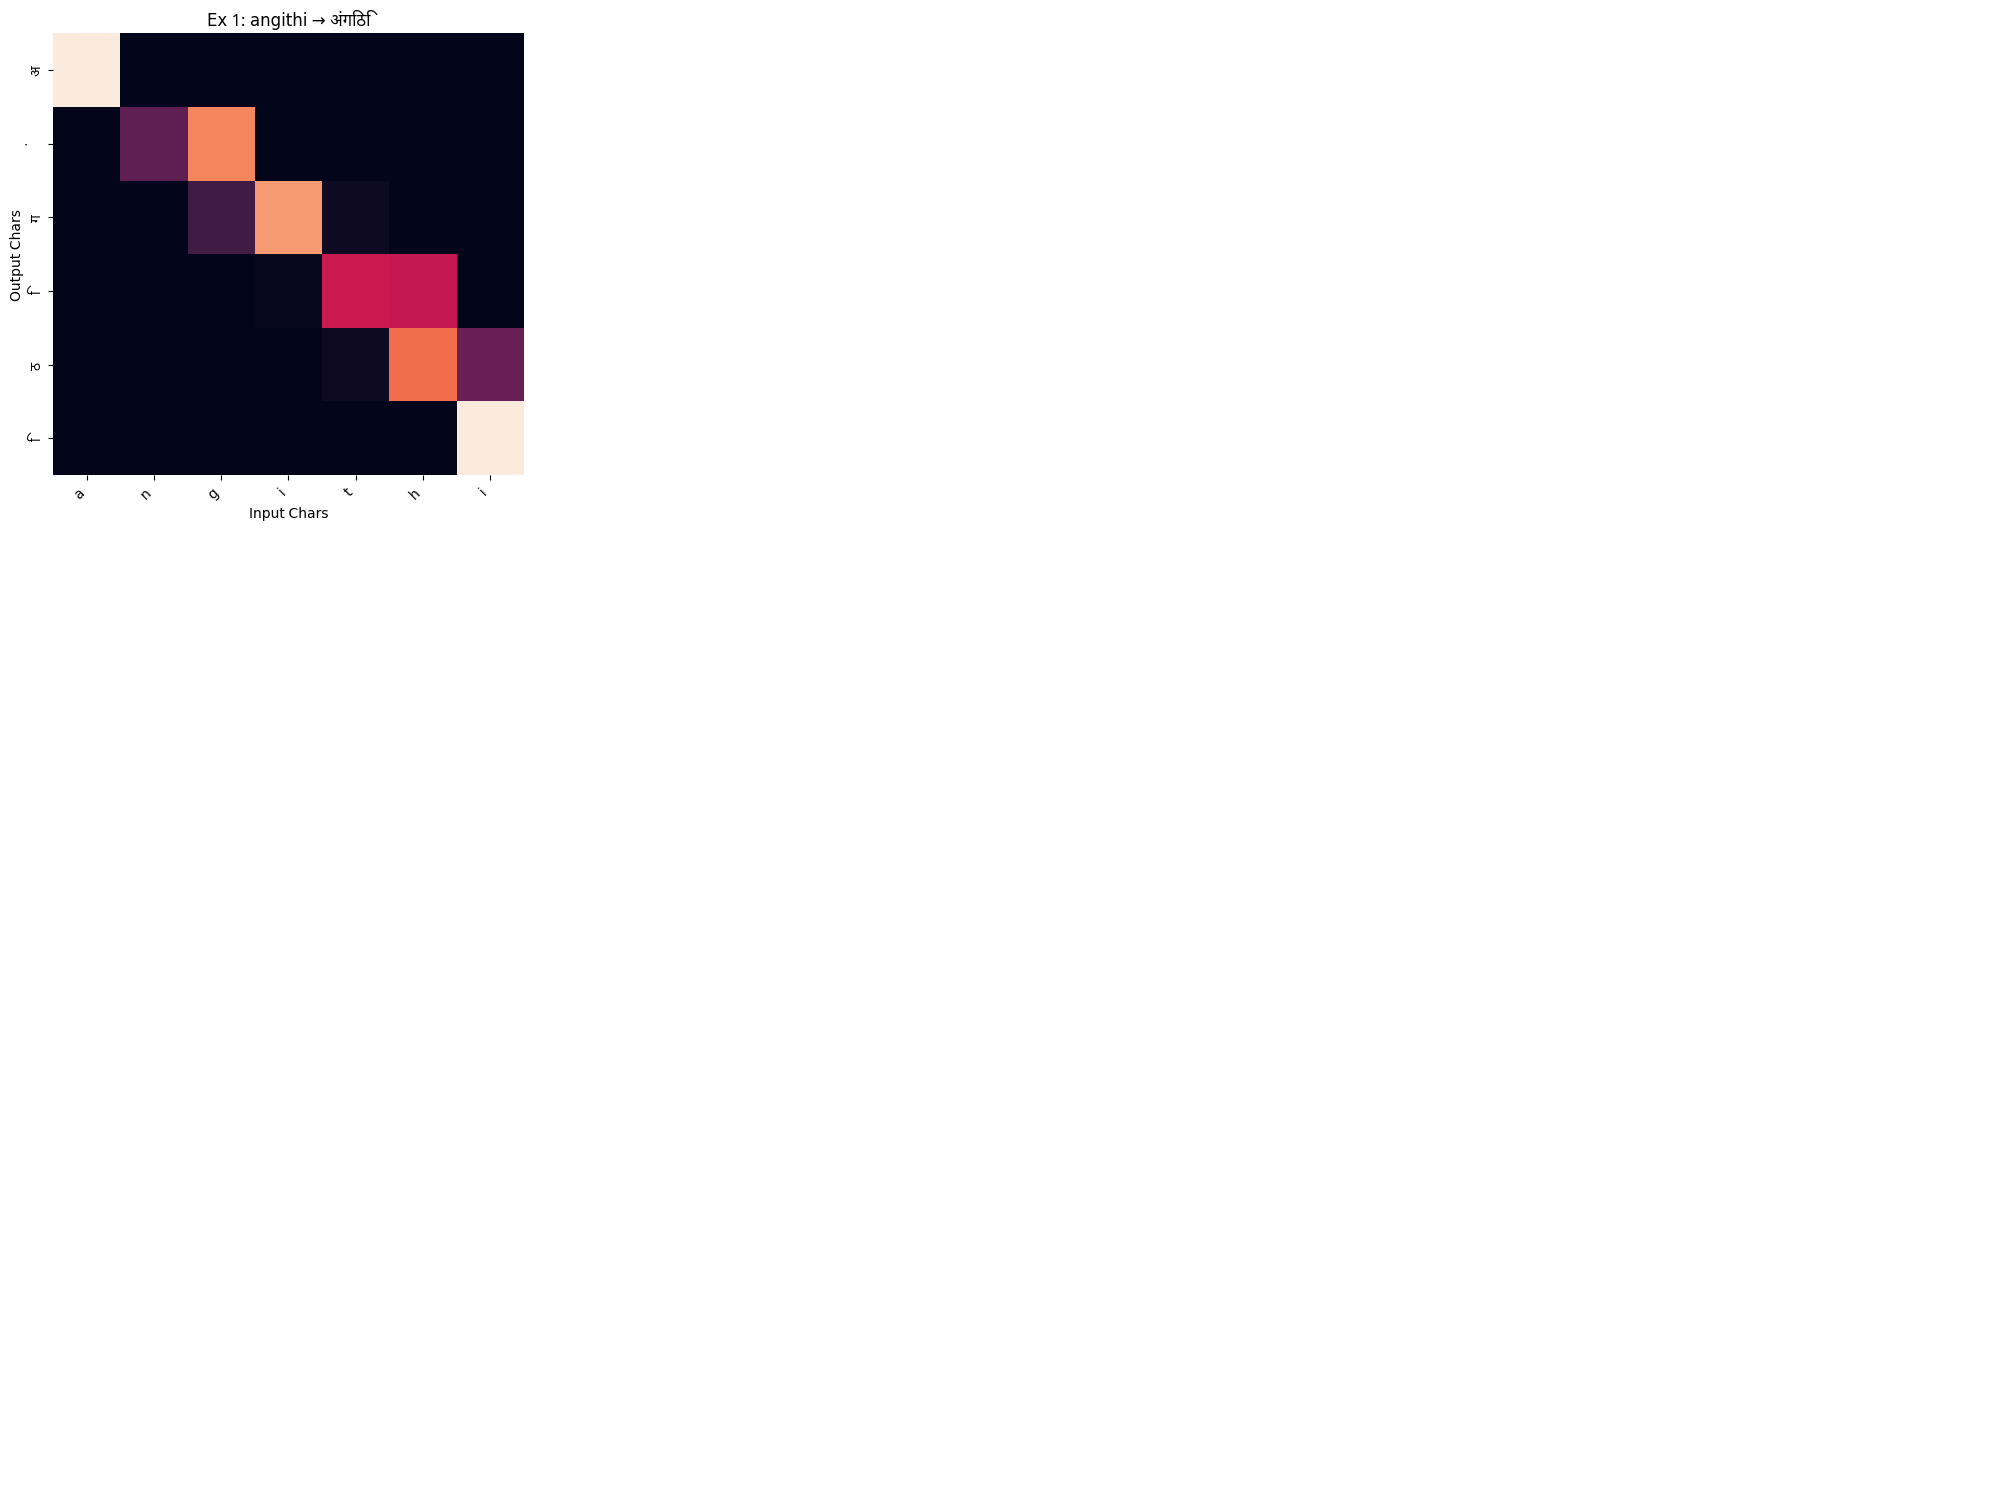

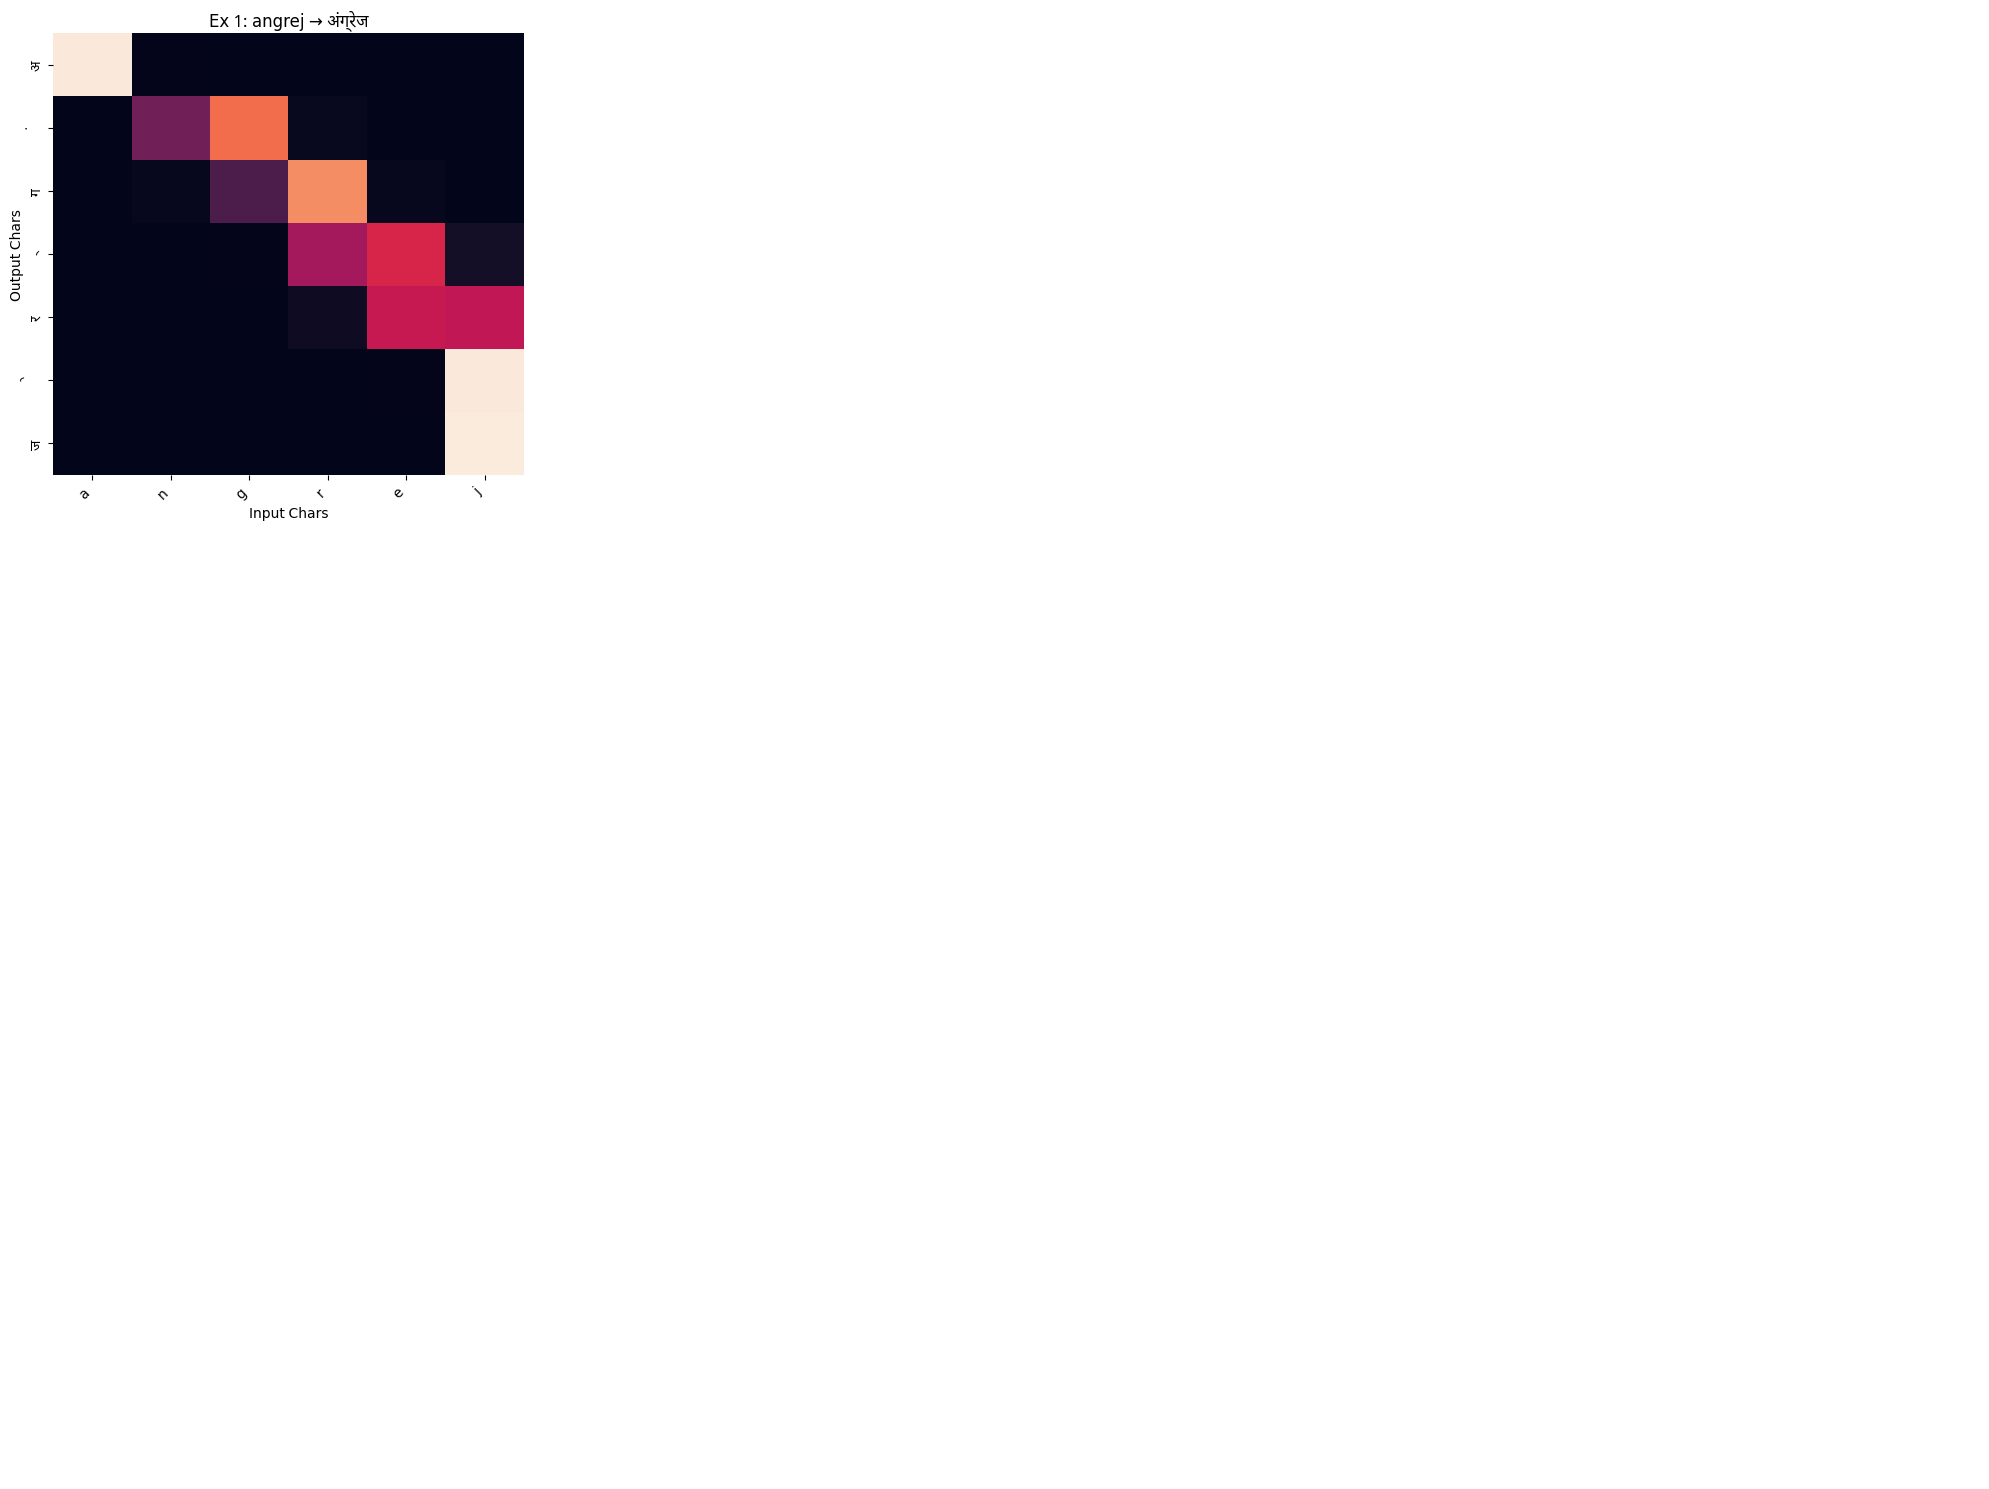

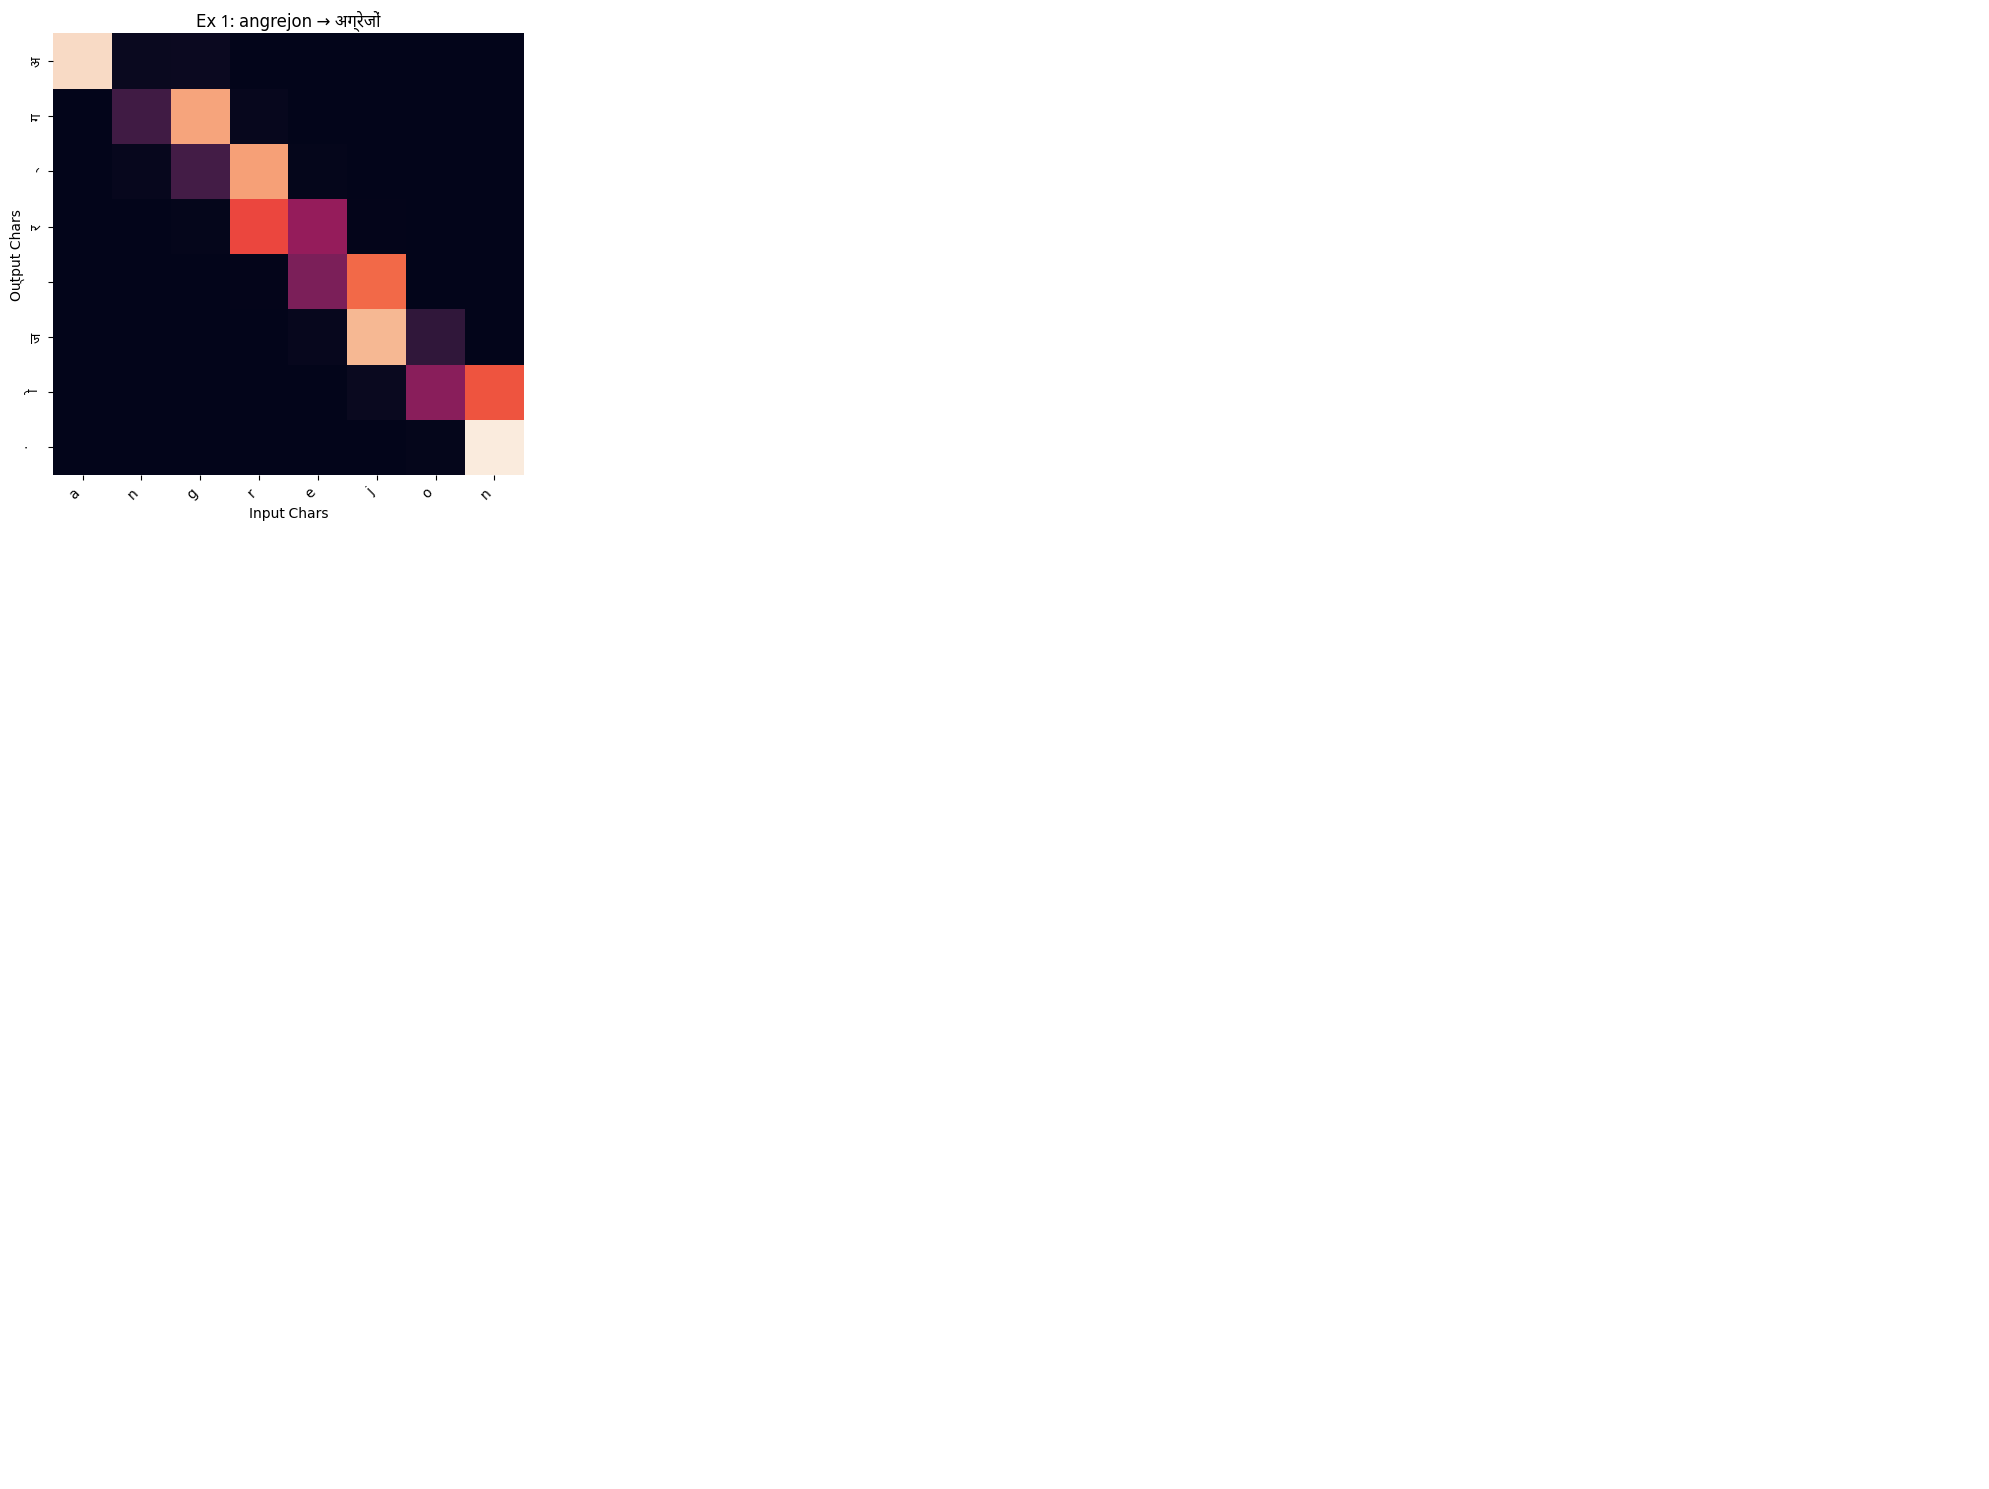

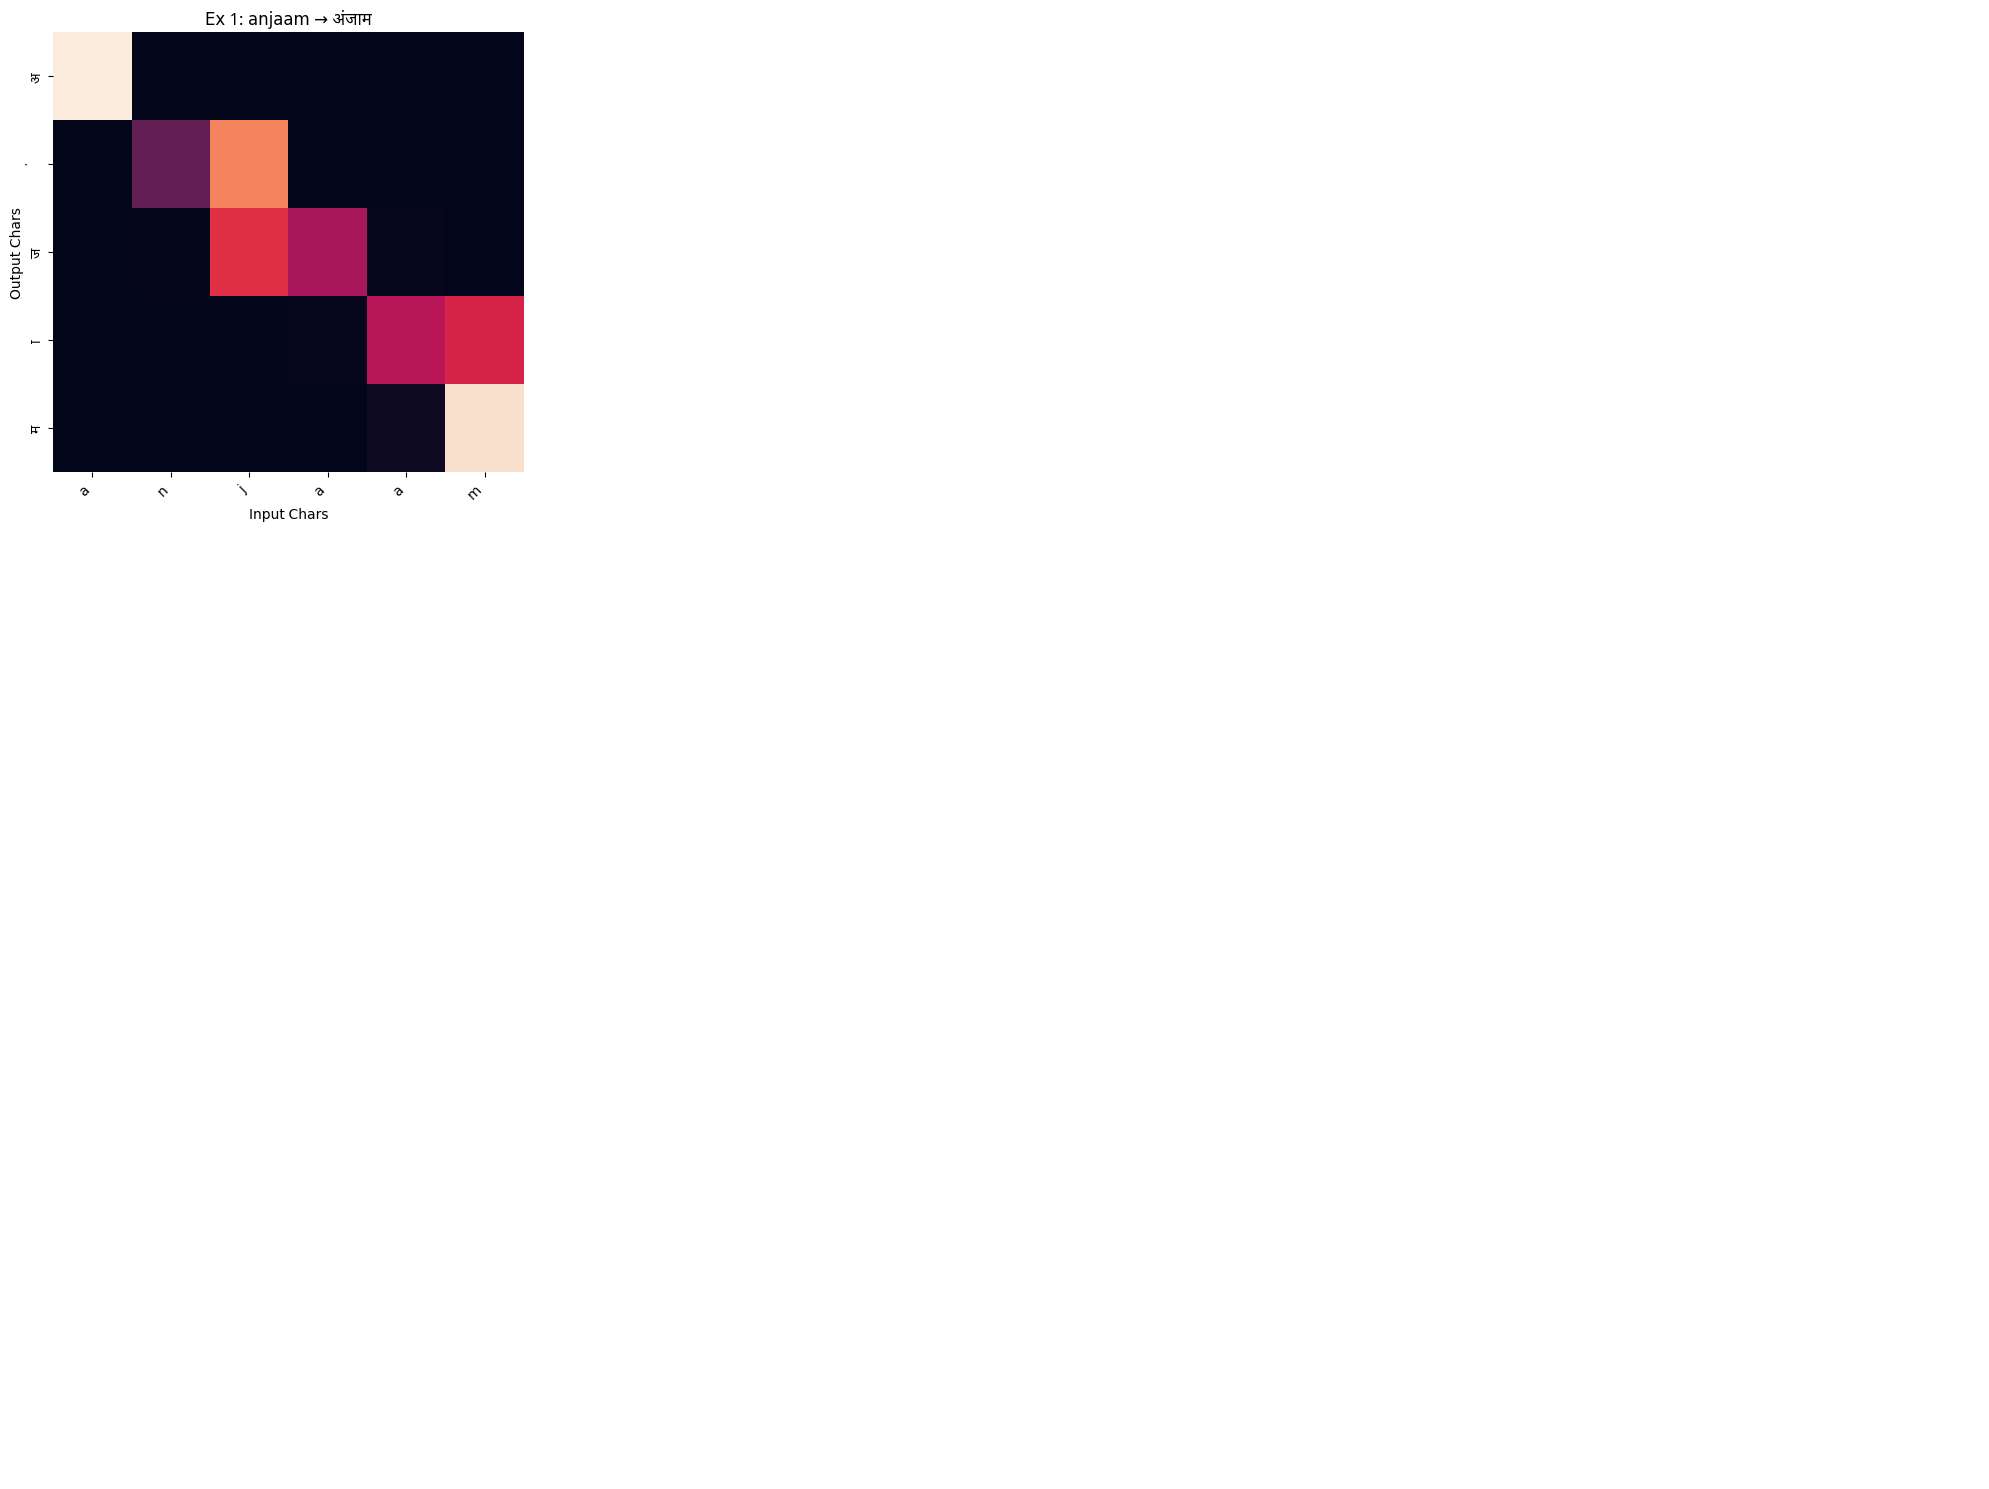

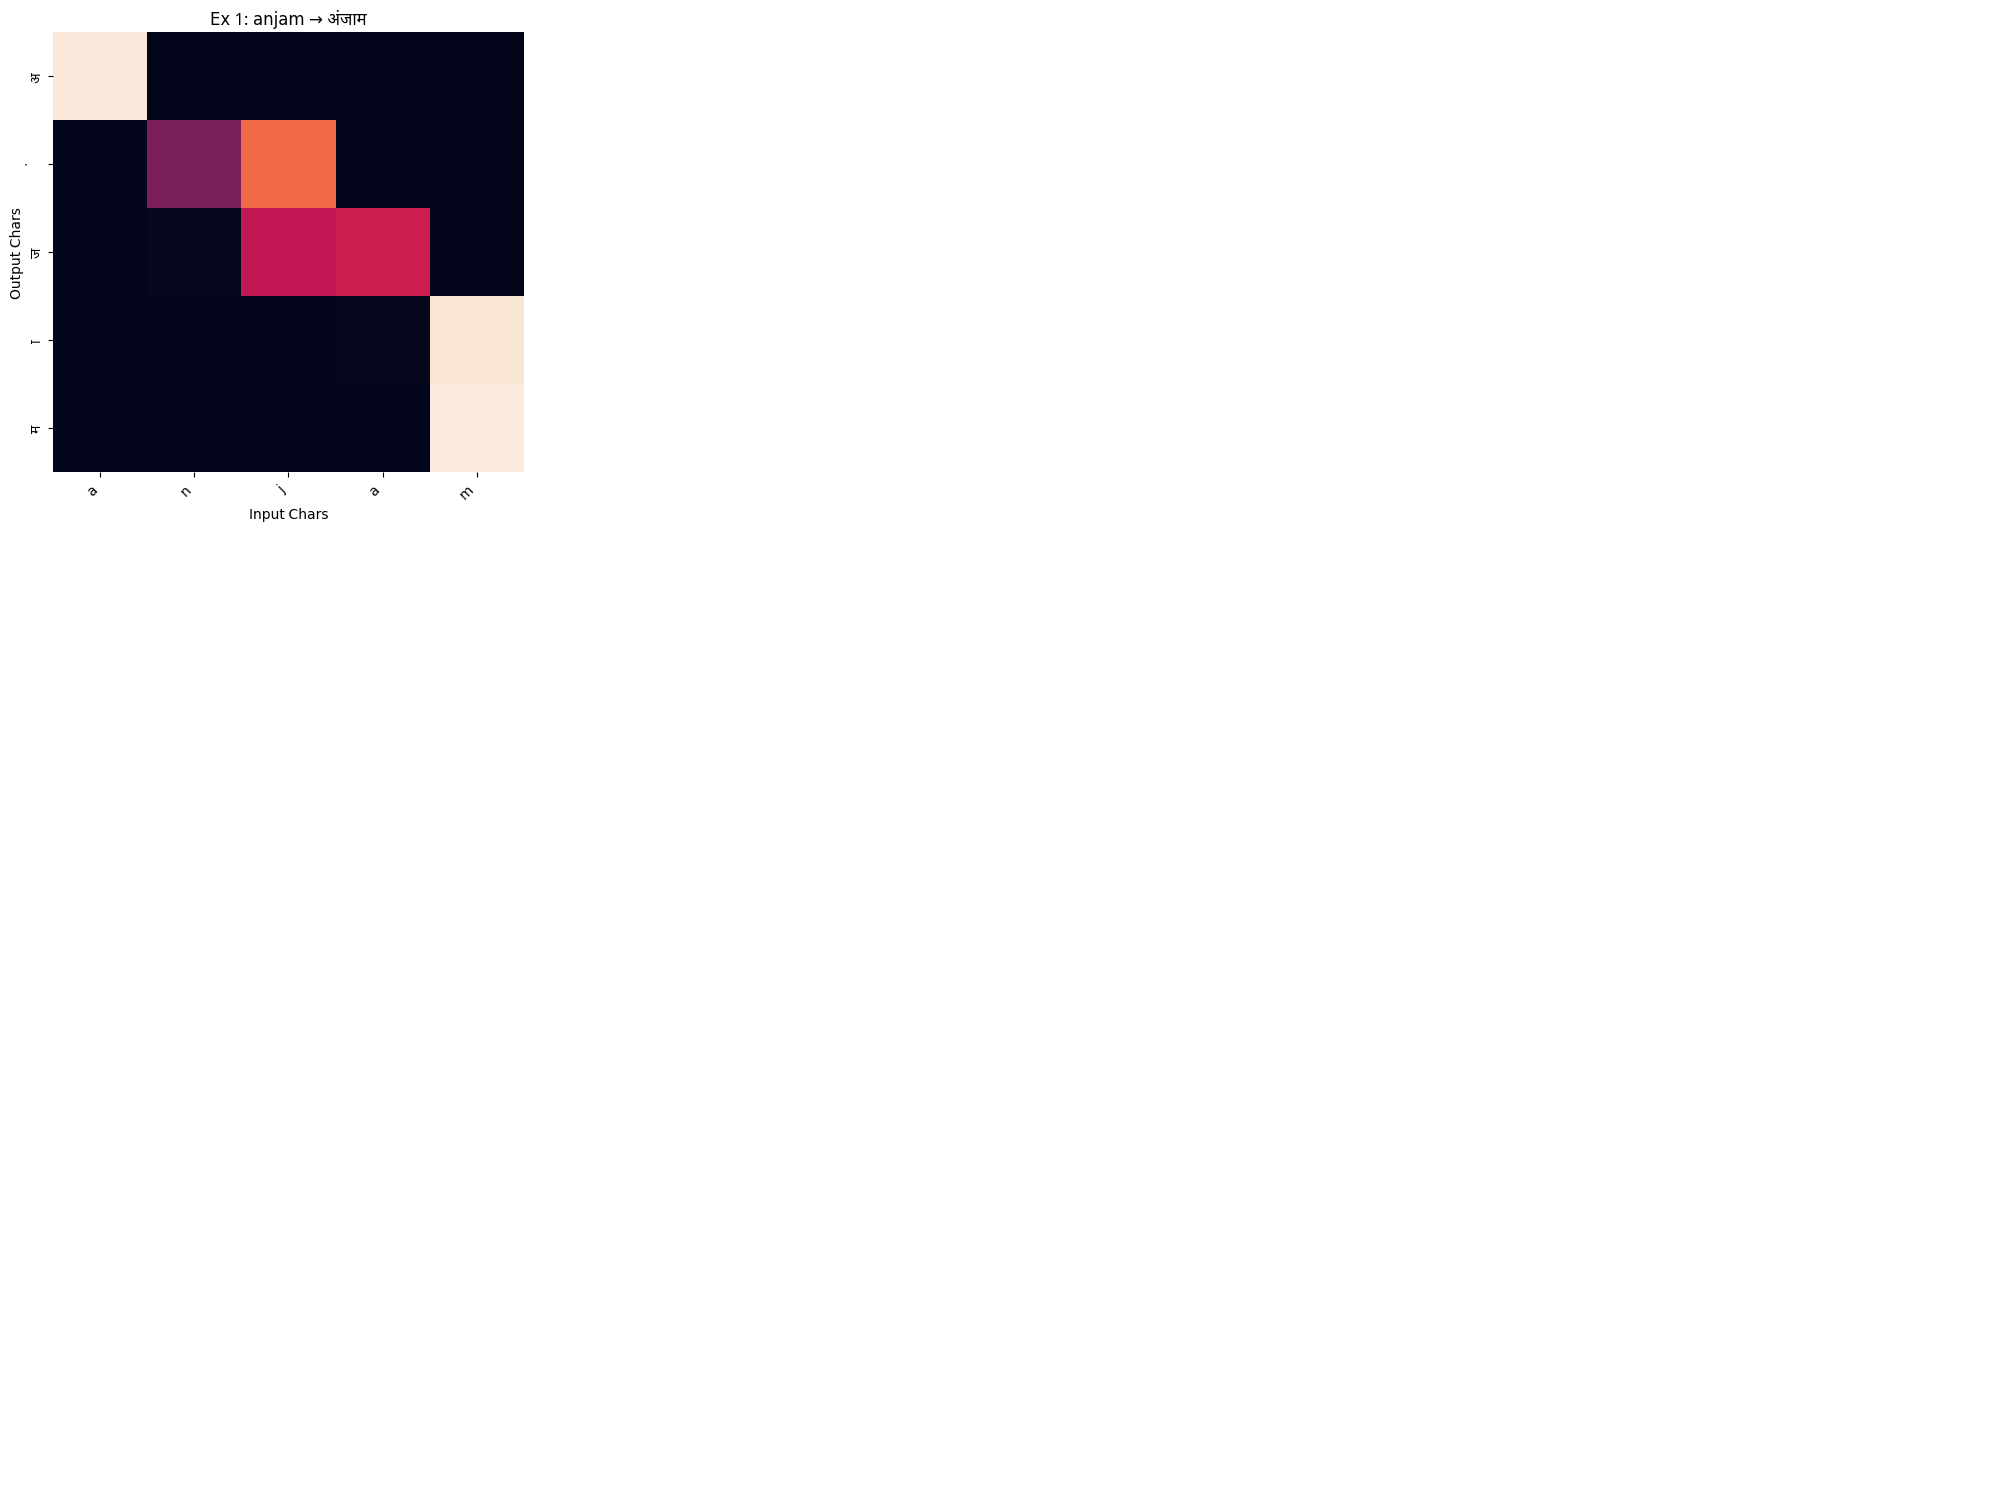

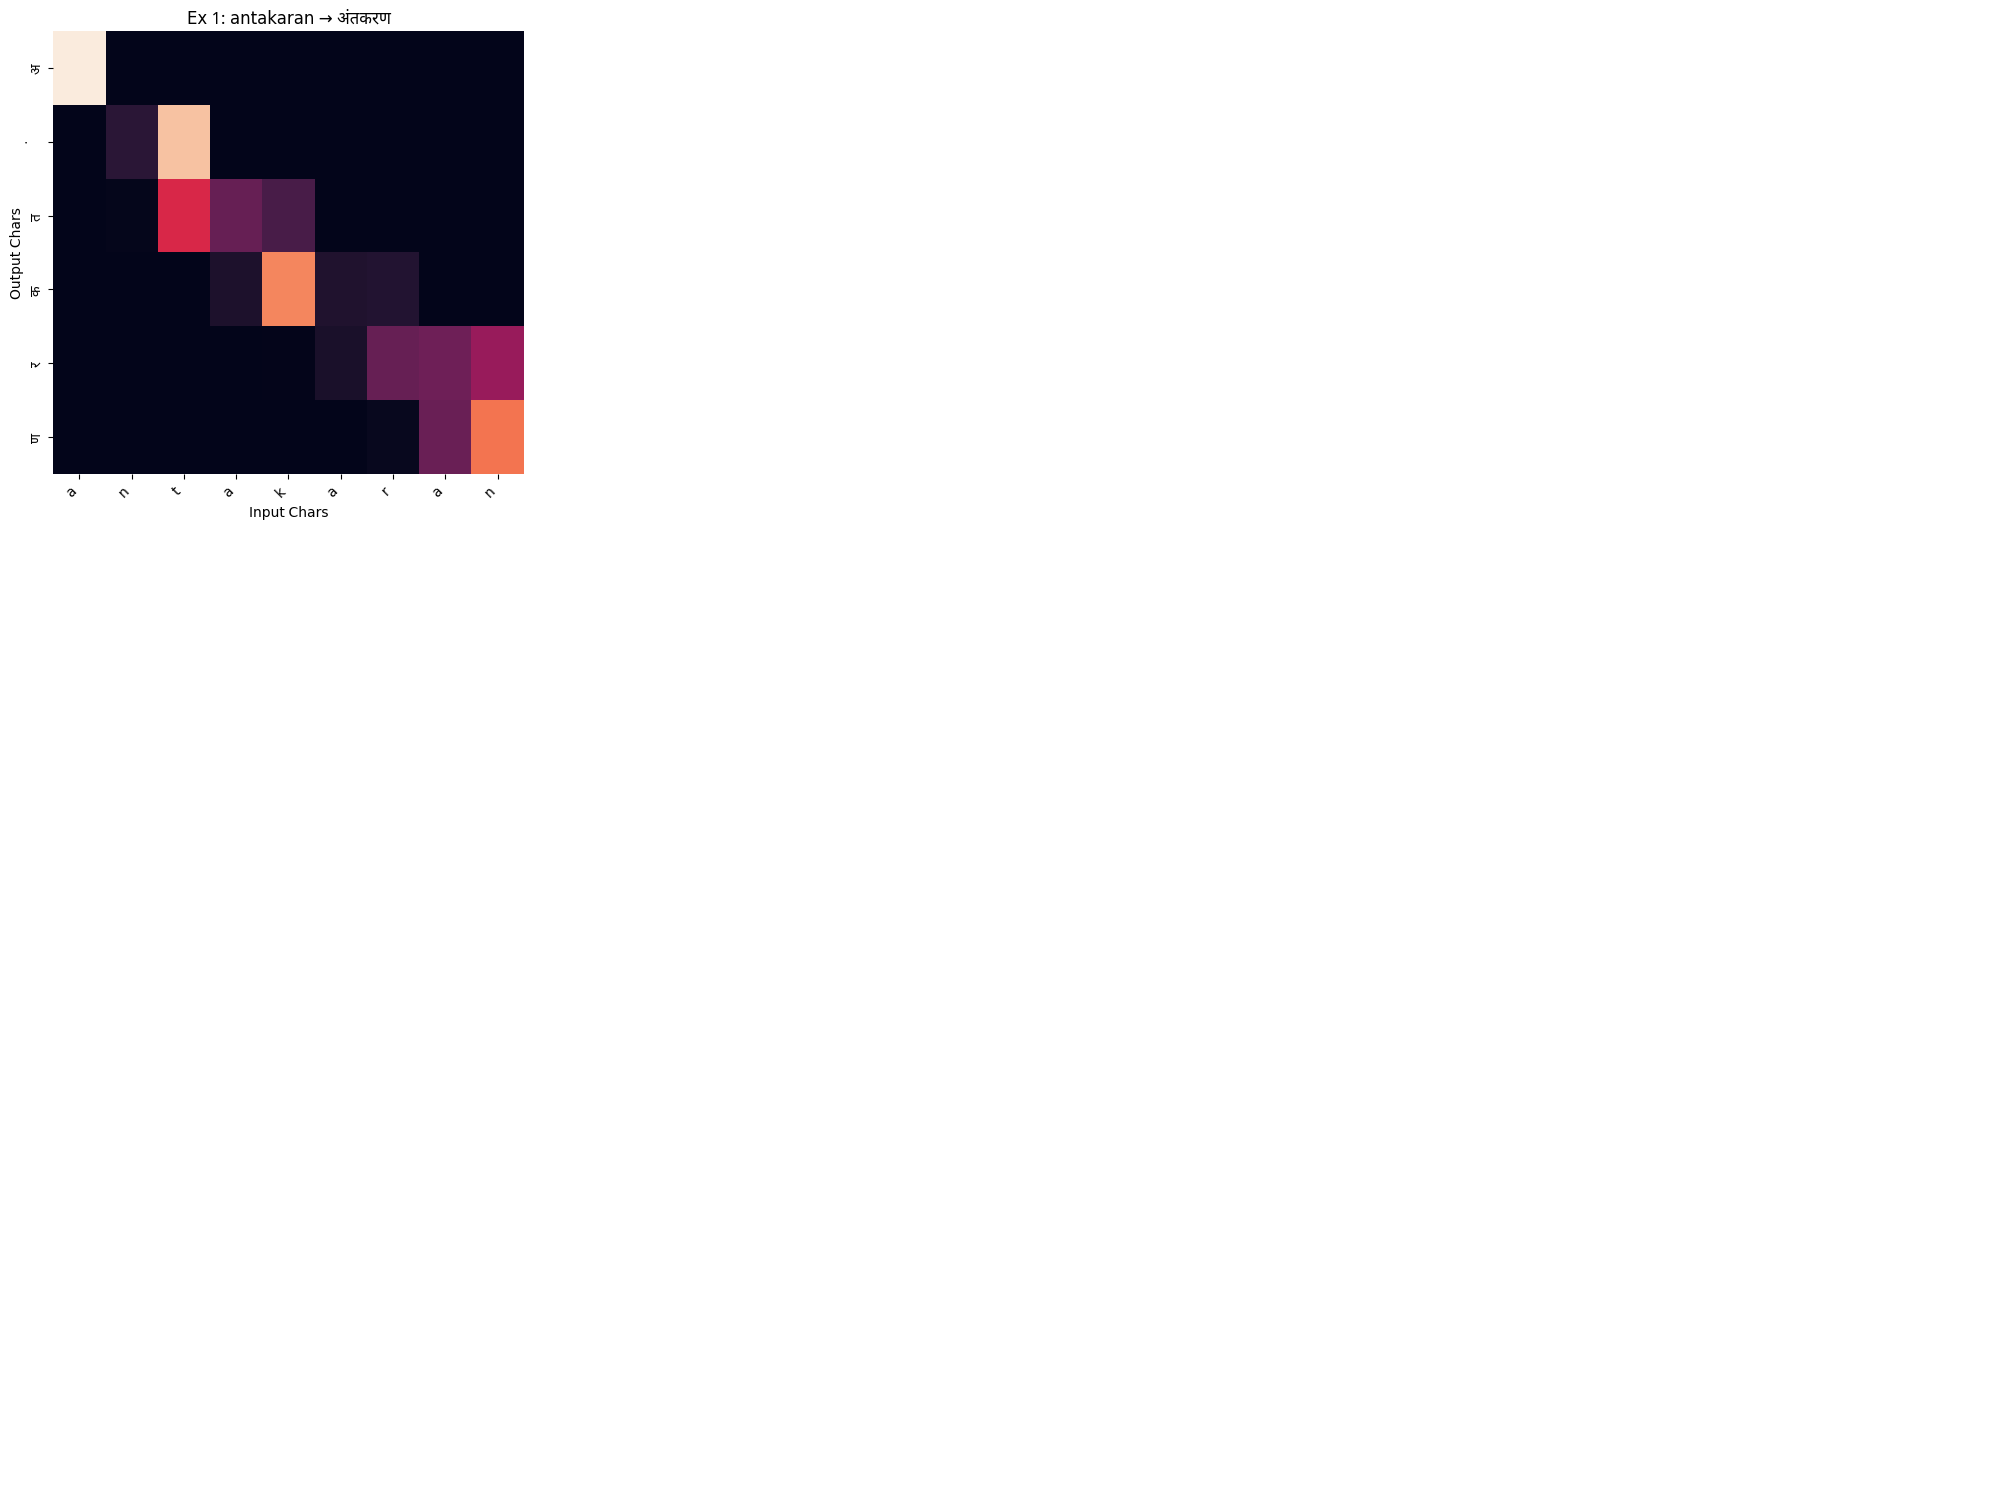

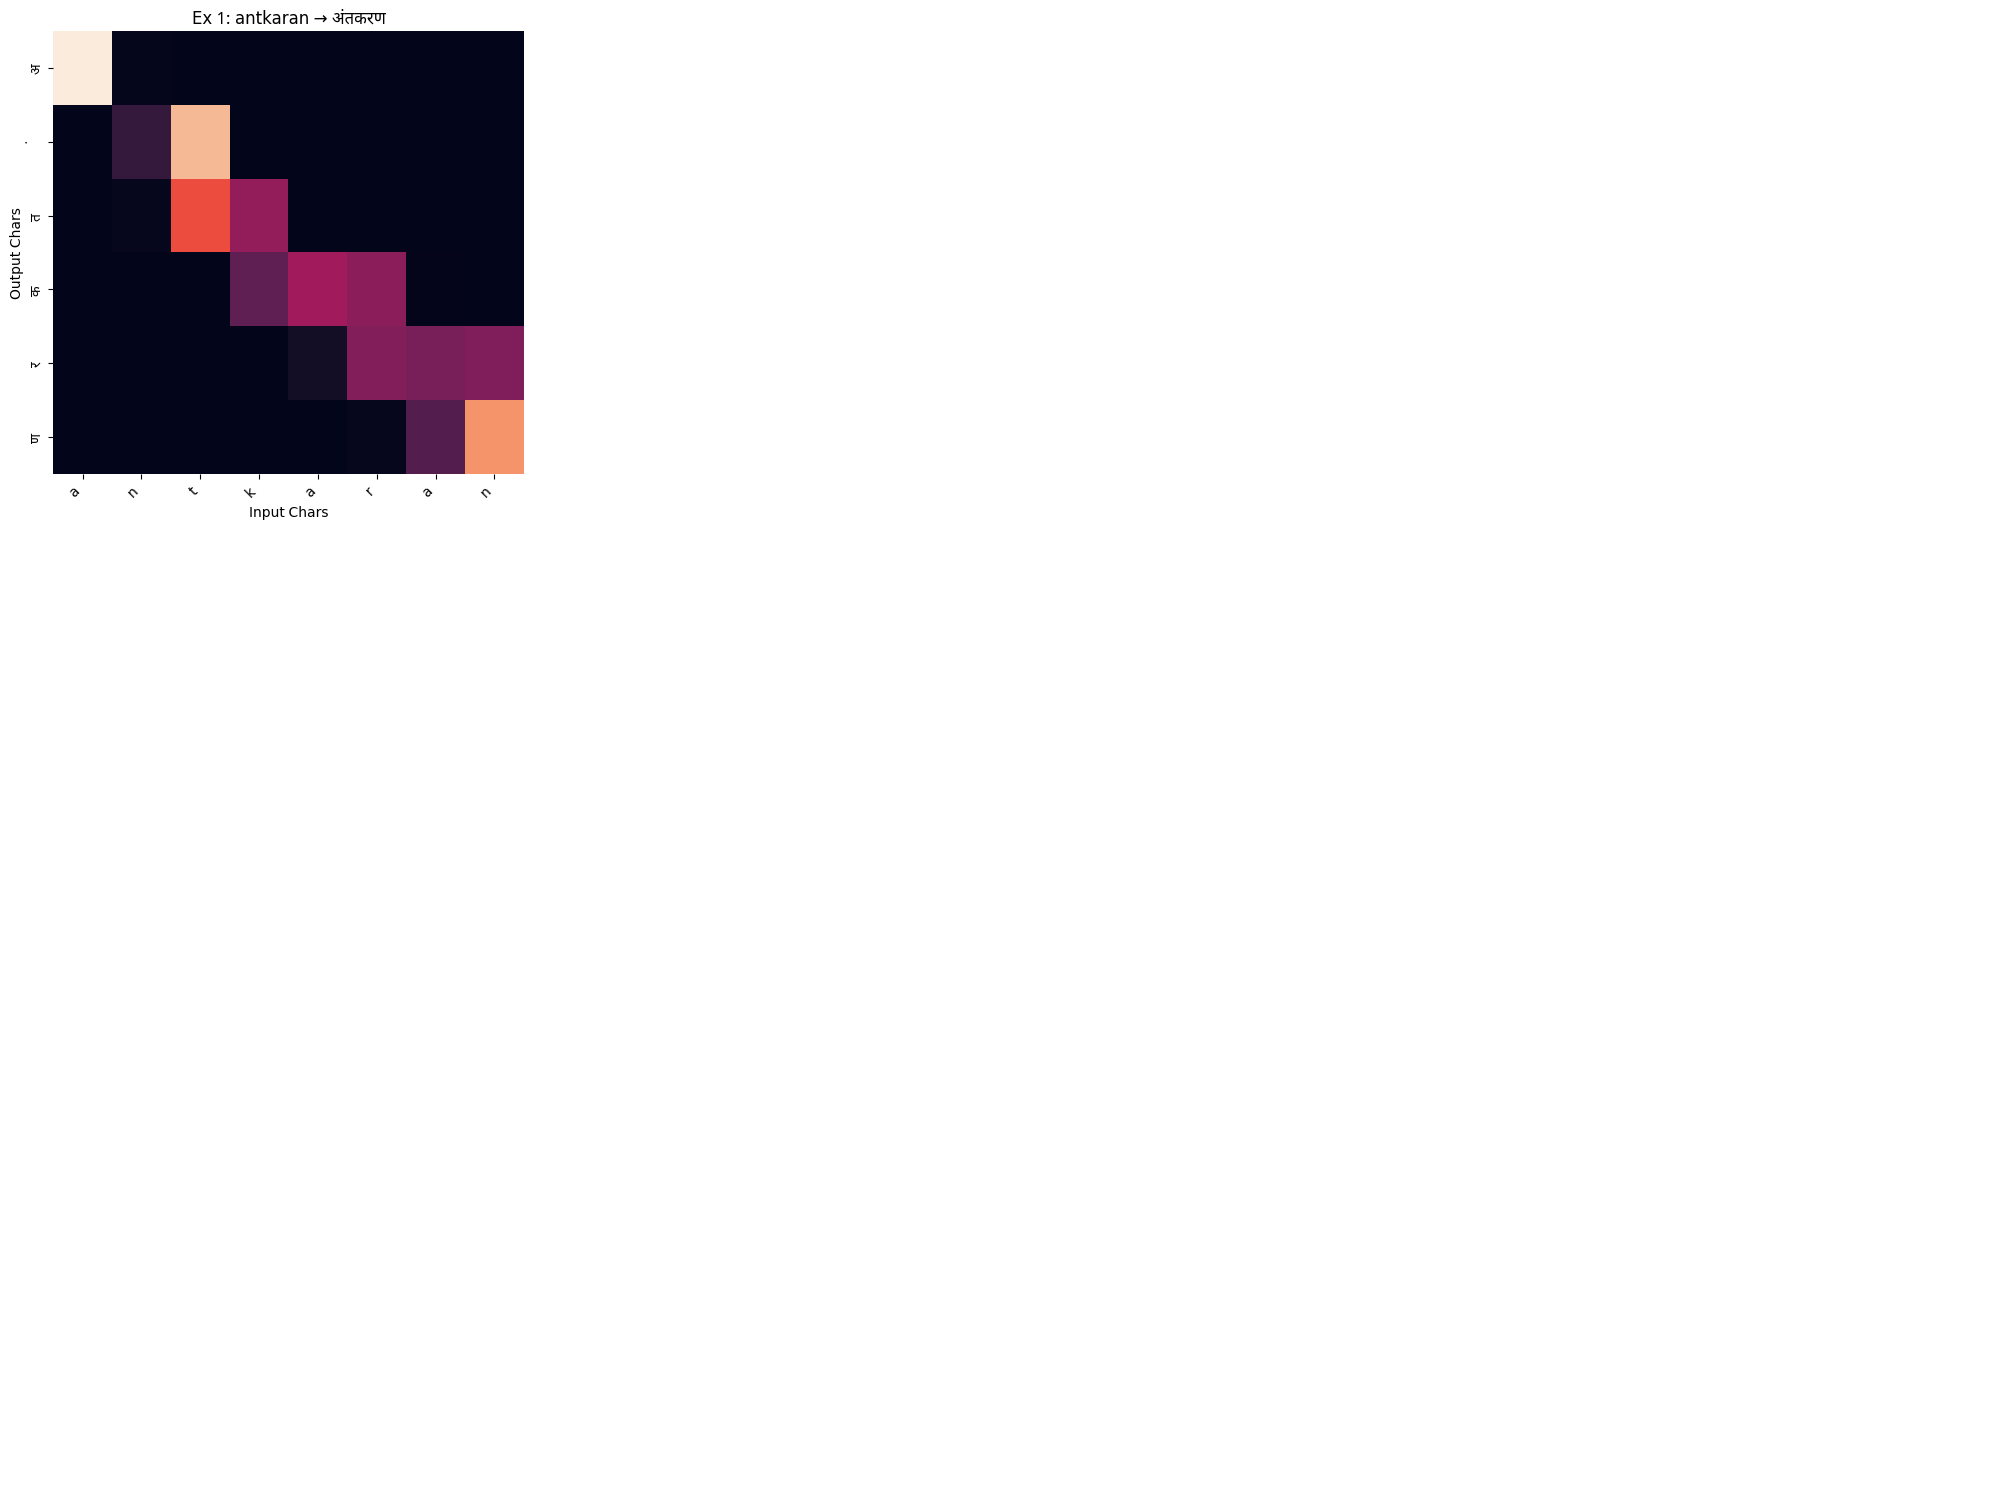

In [72]:
# wandb.login(key="2b8654ea1d7143307fd59d1ea1bda5bc9f6fef77")
# wandb.init(project="da6401_assignment_3", entity="cs24m048-iit-madras")
# Plot attention for first 10 examples
for i in range(1,11,1):
    plot_attention_grid(attention_weights[i-1:i], inputs[i-1:i], predictions[i-1:i],example=i)

In [47]:
wandb.finish()

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image
import wandb

def plot_connectivity(attention_weights, input_words, output_words, index=0, figsize=(12, 4),example=0):
    """
    Visualize which input character the model attends to most for each output character.
    Handles batched attention weights by selecting the example at `index`.
    - attention_weights: (batch_size, output_len, input_len) numpy array or tensor
    - input_words: list of input strings (batch)
    - output_words: list of output strings (batch)
    - index: which example in the batch to plot
    """
    # Extract the attention matrix for the selected example
    if hasattr(attention_weights, 'cpu'):
        attn = attention_weights[index].cpu().numpy()
    elif isinstance(attention_weights, np.ndarray):
        attn = attention_weights[index]
    else:
        attn = np.array(attention_weights[index])
    
    input_word = input_words[index]
    output_word = output_words[index]

    # Use only the relevant part of the attention matrix
    attn_cropped = attn[:len(output_word), :len(input_word)]

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(attn_cropped, cmap='Blues', alpha=0.3, aspect='auto')

    # Set ticks and labels to match the actual word lengths
    ax.set_xticks(range(len(input_word)))
    ax.set_yticks(range(len(output_word)))
    ax.set_xticklabels(list(input_word), fontsize=14)
    ax.set_yticklabels(list(output_word), fontsize=14)
    ax.set_xlabel("Input sequence", fontsize=16)
    ax.set_ylabel("Output sequence", fontsize=16)
    ax.set_title(f"Connectivity visualization for example {index}", fontsize=16)

    # For each output character, find the input character with max attention
    max_indices = attn_cropped.argmax(axis=1)  # shape: (output_len,)

    for out_i, in_i in enumerate(max_indices):
        ax.plot([in_i], [out_i], 'ro')
        ax.plot([in_i, in_i], [out_i-0.4, out_i+0.4], 'r-', alpha=0.5)

    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    pil_img = Image.open(buf)
    wandb.log({"example":example ,"connectity grid": wandb.Image(pil_img)})
    buf.close()
    plt.show()


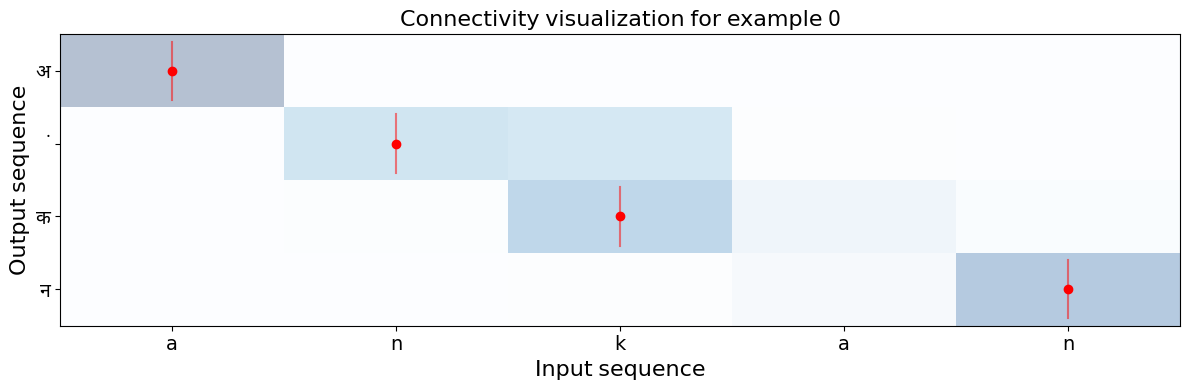

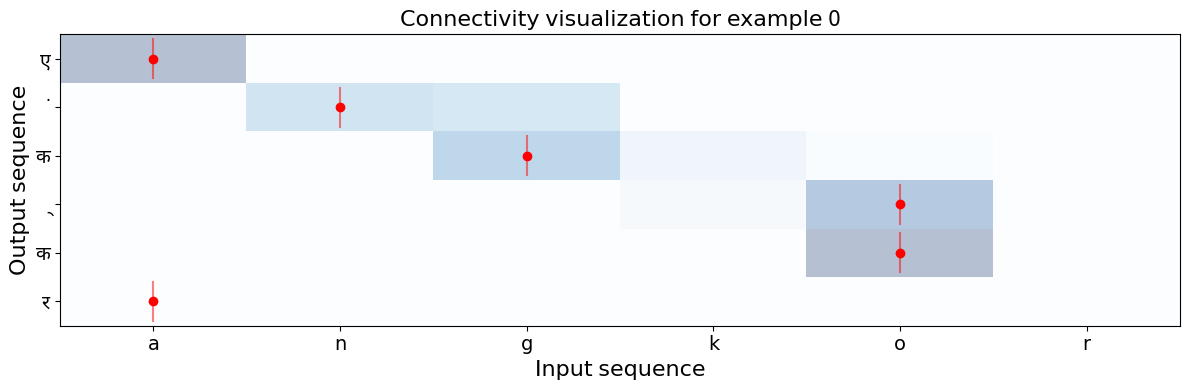

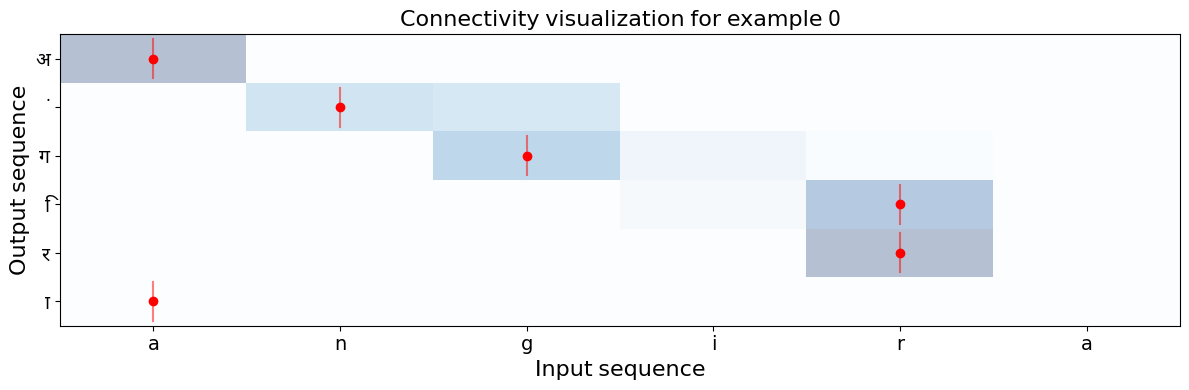

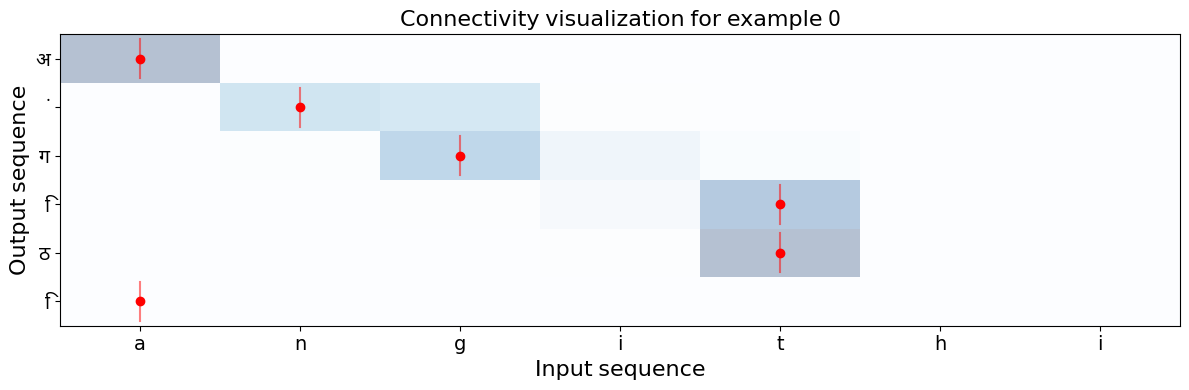

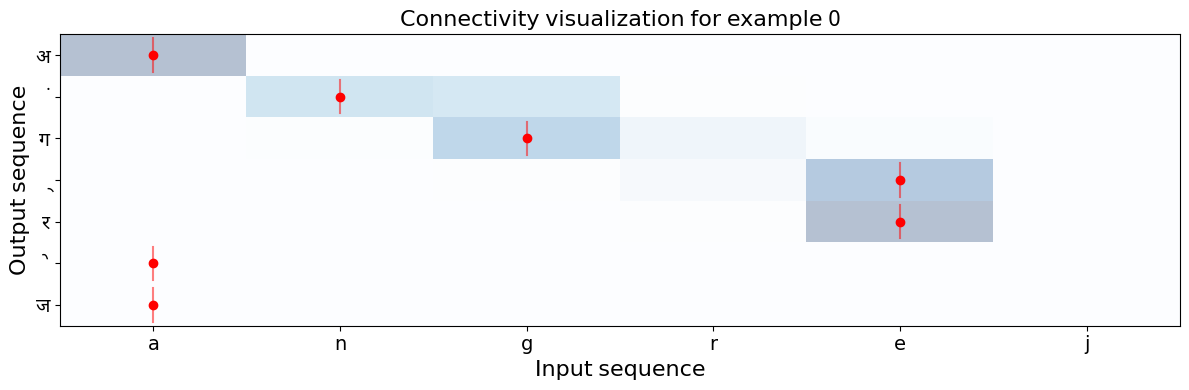

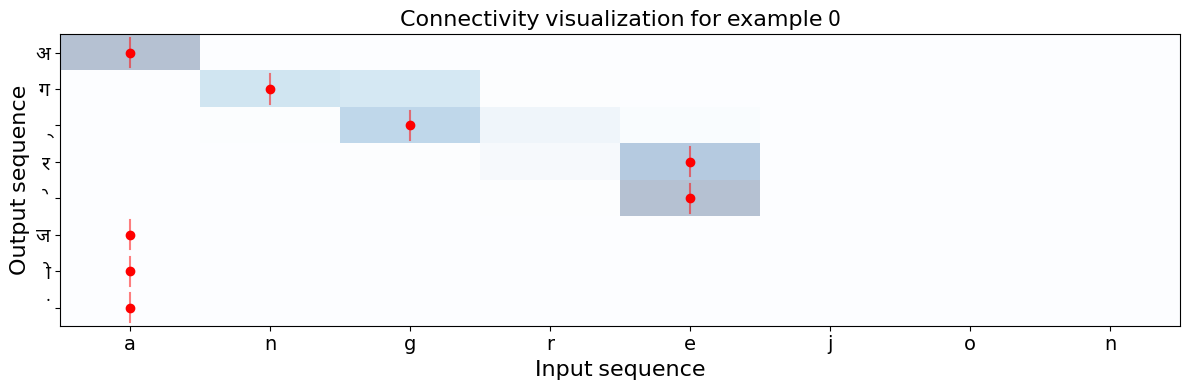

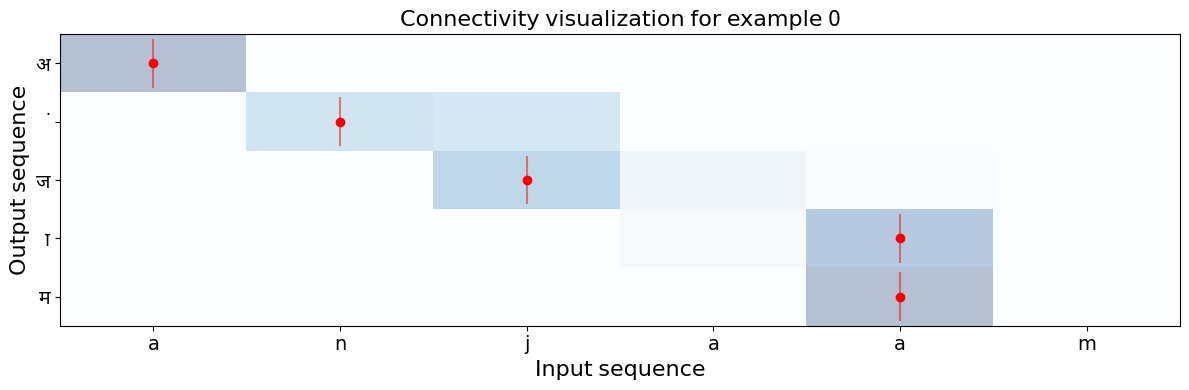

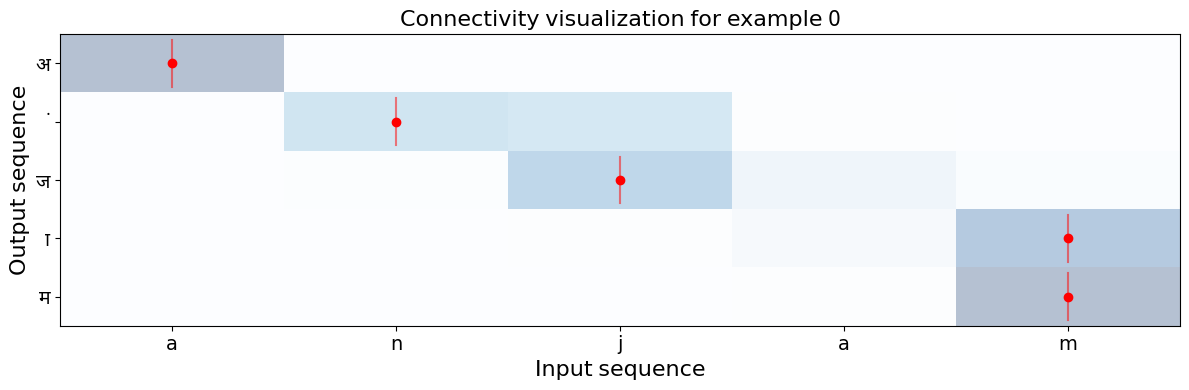

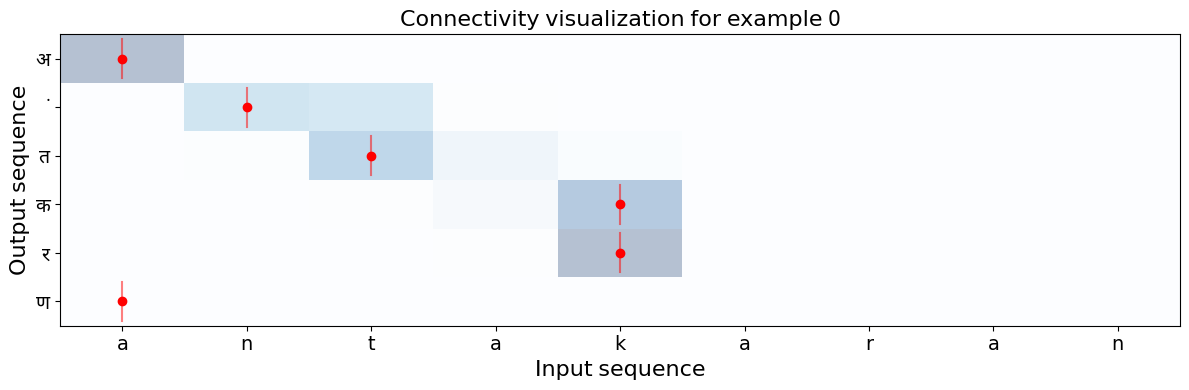

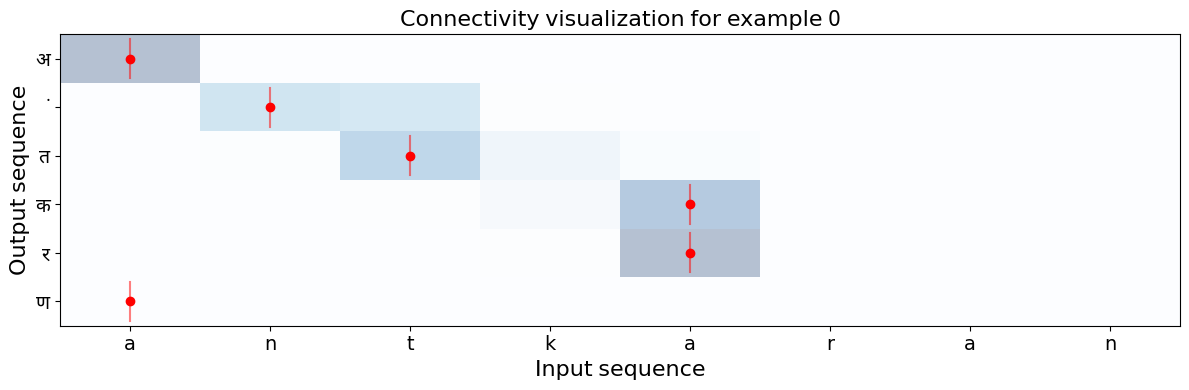

In [76]:
# wandb.login(key="2b8654ea1d7143307fd59d1ea1bda5bc9f6fef77")
# wandb.init(project="da6401_assignment_3", entity="cs24m048-iit-madras")
for i in range(1,11,1):
  plot_connectivity(attention_weights, inputs[i-1:i], predictions[i-1:i],index=0,example = i)
# wandb.finish()

In [37]:
sweep_config = {
    # sweep_config.yaml equivalent
    "method": "bayes",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "embed_dim": {
            "values": [64]
        },
        "hidden_dim": {
            "values": [256]
        },
        "num_layers": {
            "values": [2]
        },
        "cell_type": {
            "values": ["LSTM","GRU"]
        },
        "dropout": {
            "values": [0.3]
        },
        "lr": {
            "values": [0.0005]
        },
        "batch_size": {
            "values": [32]
        },
        "lang_code": {
            "value": "hi"
        },
        "epochs": {
            "value": 10
        }
    }
}
wandb.login(key="2b8654ea1d7143307fd59d1ea1bda5bc9f6fef77")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [77]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
example,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁▄▆▇▇██▇██
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▆▇▇▇▇█▇▇
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,9
example,10
loss,0.21591
test_accuracy,0.5081


In [16]:
sweep_id = wandb.sweep(sweep_config, entity="cs24m048-iit-madras", project='da6401_assignment_3')
wandb.agent(sweep_id,project='da6401_assignment_3',function=train_model,count=40)

Create sweep with ID: 8g02ulzv
Sweep URL: https://wandb.ai/cs24m048-iit-madras/da6401_assignment_3/sweeps/8g02ulzv


wandb: Agent Starting Run: llvqwy7r with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1, Loss: 1.5463650406873346, Train Accuracy: 0.10282651953690303, Val Accuracy: 0.20536800486618007, Test Accuracy: 0.23146357188910377, Validation loss: 163.83266055583954
Epoch 2, Loss: 0.7923494967727689, Train Accuracy: 0.26546219247467434, Val Accuracy: 0.27965328467153283, Test Accuracy: 0.2931777885235332, Validation loss: 146.37458285689354
Epoch 3, Loss: 0.6201474183116394, Train Accuracy: 0.3571183068017366, Val Accuracy: 0.34952858880778587, Test Accuracy: 0.34570438426821404, Validation loss: 144.08101484179497
Epoch 4, Loss: 0.5220463506758817, Train Accuracy: 0.4194509768451519, Val Accuracy: 0.3574361313868613, Test Accuracy: 0.3629714700193424, Validation loss: 140.66562539339066
Epoch 5, Loss: 0.4508311254782373, Train Accuracy: 0.47108357452966715, Val Accuracy: 0.354470802919708, Test Accuracy: 0.3608760477111541, Validation loss: 147.51940202713013
Epoch 6, Loss: 0.39810723914898255, Train Accuracy: 0.5114824529667149, Val Accuracy: 0.3606295620437956, Test Ac

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▆▇▇▇▇▇▇█
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▇▇▇▇▇▇██
val_loss,█▃▂▁▃▂▄▃▆▇
epoch,10
loss,0.26937
test_accuracy,0.38657
train_accuracy,0.62536
val_accuracy,0.38139


wandb: Agent Starting Run: 0obc724h with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 1.6101686383466818, Train Accuracy: 0.09010298222038454, Val Accuracy: 0.22735507246376813, Test Accuracy: 0.23713588348271447, Validation loss: 84.27879118919373
Epoch 2, Loss: 0.8045303315226146, Train Accuracy: 0.23251757287574945, Val Accuracy: 0.31325483091787437, Test Accuracy: 0.3183218629961588, Validation loss: 76.53936469554901
Epoch 3, Loss: 0.6459330570508016, Train Accuracy: 0.3120208376404107, Val Accuracy: 0.33559782608695654, Test Accuracy: 0.34517045454545453, Validation loss: 72.95326292514801
Epoch 4, Loss: 0.5542099385289139, Train Accuracy: 0.3656708703741989, Val Accuracy: 0.3597524154589372, Test Accuracy: 0.36611715749039697, Validation loss: 70.9154098033905
Epoch 5, Loss: 0.48862133486743603, Train Accuracy: 0.42045258769209565, Val Accuracy: 0.3549969806763285, Test Accuracy: 0.3577944942381562, Validation loss: 74.1775393486023
Epoch 6, Loss: 0.4376546803500649, Train Accuracy: 0.466817199021432, Val Accuracy: 0.3732638888888889, Test Accuracy

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▆▇▇█▇█▇▇
train_accuracy,▁▃▄▅▆▇▇███
val_accuracy,▁▅▆▇▇████▇
val_loss,█▄▂▁▃▃▂▃▅▄
epoch,10
loss,0.31422
test_accuracy,0.37866
train_accuracy,0.54525
val_accuracy,0.36383


wandb: Agent Starting Run: nhmm8m9t with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1, Loss: 1.9669301508132007, Train Accuracy: 0.03883799359106885, Val Accuracy: 0.10733695652173914, Test Accuracy: 0.12455985915492958, Validation loss: 102.71021503210068
Epoch 2, Loss: 1.0874047014544221, Train Accuracy: 0.1672782716559851, Val Accuracy: 0.21633454106280195, Test Accuracy: 0.22841309218950065, Validation loss: 84.34467405080795
Epoch 3, Loss: 0.8792656910229696, Train Accuracy: 0.24022939494176831, Val Accuracy: 0.26419082125603865, Test Accuracy: 0.27132682458386687, Validation loss: 80.20207172632217
Epoch 4, Loss: 0.7791983257499342, Train Accuracy: 0.28386762628350903, Val Accuracy: 0.2881944444444445, Test Accuracy: 0.2977152688860435, Validation loss: 76.78486204147339
Epoch 5, Loss: 0.7073408773252484, Train Accuracy: 0.32065760457583903, Val Accuracy: 0.30917874396135264, Test Accuracy: 0.3054177336747759, Validation loss: 75.08805358409882
Epoch 6, Loss: 0.6580034537960583, Train Accuracy: 0.3401202105299428, Val Accuracy: 0.3209541062801932, Test Acc

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▆▇▇▇████
train_accuracy,▁▃▅▅▆▆▇▇██
val_accuracy,▁▄▆▆▇▇███▇
val_loss,█▄▃▂▁▁▁▂▁▂
epoch,10
loss,0.53311
test_accuracy,0.33621
train_accuracy,0.43495
val_accuracy,0.3208


wandb: Agent Starting Run: nbwpu0o2 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1, Loss: 1.8706200828859327, Train Accuracy: 0.05101754703328509, Val Accuracy: 0.13017031630170314, Test Accuracy: 0.1464982269503546, Validation loss: 198.6498870253563
Epoch 2, Loss: 1.0415631684484081, Train Accuracy: 0.17197449348769897, Val Accuracy: 0.23471715328467152, Test Accuracy: 0.24631286266924562, Validation loss: 167.33233657479286
Epoch 3, Loss: 0.8423488106465374, Train Accuracy: 0.2316434515195369, Val Accuracy: 0.28102189781021897, Test Accuracy: 0.28066569954867826, Validation loss: 153.34061989188194
Epoch 4, Loss: 0.7442607240031666, Train Accuracy: 0.27697178002894357, Val Accuracy: 0.29257907542579076, Test Accuracy: 0.30492424242424243, Validation loss: 149.6889991760254
Epoch 5, Loss: 0.6780339725067578, Train Accuracy: 0.31386577424023154, Val Accuracy: 0.3144008515815085, Test Accuracy: 0.32984767891682787, Validation loss: 148.7092351615429
Epoch 6, Loss: 0.6270275893371806, Train Accuracy: 0.3412445730824892, Val Accuracy: 0.2998023114355231, Test A

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▅▆▇▆▇▇██
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▆▆▇▆▇▇██
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
loss,0.49073
test_accuracy,0.36388
train_accuracy,0.42712
val_accuracy,0.35386


wandb: Agent Starting Run: 7bgjqfce with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 2


Epoch 1, Loss: 2.1181828152771107, Train Accuracy: 0.03174962097718972, Val Accuracy: 0.10295893719806763, Test Accuracy: 0.12077864916773369, Validation loss: 104.73598635196686
Epoch 2, Loss: 1.0880527449758284, Train Accuracy: 0.1648103163117635, Val Accuracy: 0.2105978260869565, Test Accuracy: 0.21866997439180538, Validation loss: 85.93458259105682
Epoch 3, Loss: 0.8443987196157706, Train Accuracy: 0.24543880504444904, Val Accuracy: 0.2758152173913043, Test Accuracy: 0.27878921254801536, Validation loss: 78.86905497312546
Epoch 4, Loss: 0.7138507142339533, Train Accuracy: 0.2940807835435187, Val Accuracy: 0.2964221014492754, Test Accuracy: 0.29705505761843787, Validation loss: 75.98560589551926
Epoch 5, Loss: 0.6225981481168447, Train Accuracy: 0.33680376093997655, Val Accuracy: 0.32065217391304346, Test Accuracy: 0.3282450384122919, Validation loss: 73.9218197464943
Epoch 6, Loss: 0.5509364488500934, Train Accuracy: 0.37496554338088345, Val Accuracy: 0.338088768115942, Test Accura

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁▄▆▆▇▇▇███
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▆▆▇▇████
val_loss,█▄▃▂▂▁▁▁▁▂
epoch,10
loss,0.36163
test_accuracy,0.35329
train_accuracy,0.48803
val_accuracy,0.35145


wandb: Agent Starting Run: 7gday7ds with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 2.7162633225127686, Train Accuracy: 0.00027134587554269177, Val Accuracy: 0.0004528985507246377, Test Accuracy: 0.0006602112676056338, Validation loss: 176.00136160850525
Epoch 2, Loss: 2.165597996387399, Train Accuracy: 0.001808972503617945, Val Accuracy: 0.004755434782608696, Test Accuracy: 0.007262323943661972, Validation loss: 158.3105138540268
Epoch 3, Loss: 1.8802027108872852, Train Accuracy: 0.0037083936324167873, Val Accuracy: 0.0192481884057971, Test Accuracy: 0.025088028169014086, Validation loss: 142.45455932617188
Epoch 4, Loss: 1.7181613212383948, Train Accuracy: 0.009373277169044174, Val Accuracy: 0.03638285024154589, Test Accuracy: 0.042693661971830985, Validation loss: 132.6531467437744
Epoch 5, Loss: 1.624369905930007, Train Accuracy: 0.013589905933429812, Val Accuracy: 0.043704710144927536, Test Accuracy: 0.053477112676056336, Validation loss: 131.15465664863586
Epoch 6, Loss: 1.5410427213922768, Train Accuracy: 0.014087373371924746, Val Accuracy: 0.061

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
test_accuracy,▁▁▂▄▄▅▅▇▇█
train_accuracy,▁▁▂▃▄▄▄▆██
val_accuracy,▁▁▂▃▄▅▅▆█▇
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
loss,1.32924
test_accuracy,0.11642
train_accuracy,0.03055
val_accuracy,0.0942


wandb: Agent Starting Run: dqi5ef49 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 1.7770841014713006, Train Accuracy: 0.07471056439942113, Val Accuracy: 0.19905717761557176, Test Accuracy: 0.21085186976144424, Validation loss: 174.0538676083088
Epoch 2, Loss: 0.8403957643143175, Train Accuracy: 0.2511713096960926, Val Accuracy: 0.3152372262773723, Test Accuracy: 0.31808107672469377, Validation loss: 145.98128154873848
Epoch 3, Loss: 0.6409017155553428, Train Accuracy: 0.3391325976845152, Val Accuracy: 0.35621958637469586, Test Accuracy: 0.35102353320438423, Validation loss: 139.19318908452988
Epoch 4, Loss: 0.5404366939483607, Train Accuracy: 0.41097594066570187, Val Accuracy: 0.35796836982968366, Test Accuracy: 0.3675451321727917, Validation loss: 138.90131118893623
Epoch 5, Loss: 0.46727604290683433, Train Accuracy: 0.4533013748191027, Val Accuracy: 0.3730991484184915, Test Accuracy: 0.3820519019987105, Validation loss: 137.4485021531582
Epoch 6, Loss: 0.4102089211193766, Train Accuracy: 0.4855236975397974, Val Accuracy: 0.3825273722627737, Test Acc

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▆▇▇█████
train_accuracy,▁▃▄▅▆▆▇▇▇█
val_accuracy,▁▅▇▇██████
val_loss,█▃▁▁▁▂▃▃▄▄
epoch,10
loss,0.27246
test_accuracy,0.39656
train_accuracy,0.62397
val_accuracy,0.38344


wandb: Agent Starting Run: c9tfh95a with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 2.1468659116631823, Train Accuracy: 0.034194964165116117, Val Accuracy: 0.13745471014492755, Test Accuracy: 0.15380921895006402, Validation loss: 98.75979524850845
Epoch 2, Loss: 0.9636199379450333, Train Accuracy: 0.19692173178967678, Val Accuracy: 0.2655495169082126, Test Accuracy: 0.28273047375160054, Validation loss: 79.05822908878326
Epoch 3, Loss: 0.7242914105721044, Train Accuracy: 0.2944178123492523, Val Accuracy: 0.32669082125603865, Test Accuracy: 0.32776488476312415, Validation loss: 72.80094796419144
Epoch 4, Loss: 0.5974678100449304, Train Accuracy: 0.3343541106746606, Val Accuracy: 0.36133756038647347, Test Accuracy: 0.35907490396927016, Validation loss: 70.54853838682175
Epoch 5, Loss: 0.5116777982880859, Train Accuracy: 0.3885306836193233, Val Accuracy: 0.35182669082125606, Test Accuracy: 0.3608154609475032, Validation loss: 69.85797798633575
Epoch 6, Loss: 0.44467078537482085, Train Accuracy: 0.4355984253325064, Val Accuracy: 0.3738677536231884, Test Acc

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▆▇▇███▇▇
train_accuracy,▁▃▄▅▆▆▇▇▇█
val_accuracy,▁▅▆▇▇███▇█
val_loss,█▃▂▁▁▂▁▂▂▂
epoch,10
loss,0.29169
test_accuracy,0.37314
train_accuracy,0.57975
val_accuracy,0.38723


wandb: Agent Starting Run: q3a5d2zr with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 2.020530484433457, Train Accuracy: 0.04902638515608849, Val Accuracy: 0.1434933574879227, Test Accuracy: 0.1599511843790013, Validation loss: 94.97700542211533
Epoch 2, Loss: 0.9282608167652456, Train Accuracy: 0.22315398663083177, Val Accuracy: 0.27770229468599034, Test Accuracy: 0.28601152368758004, Validation loss: 79.66348087787628
Epoch 3, Loss: 0.7099105911558513, Train Accuracy: 0.31097960168148303, Val Accuracy: 0.3137832125603865, Test Accuracy: 0.3297855313700384, Validation loss: 73.89619851112366
Epoch 4, Loss: 0.5834993396153844, Train Accuracy: 0.37359266246295914, Val Accuracy: 0.34125905797101447, Test Accuracy: 0.3478513124199744, Validation loss: 73.45979863405228
Epoch 5, Loss: 0.5059882718557559, Train Accuracy: 0.4180190889669906, Val Accuracy: 0.34903381642512077, Test Accuracy: 0.3548735595390525, Validation loss: 72.73005563020706
Epoch 6, Loss: 0.43486836802769674, Train Accuracy: 0.45675263593136245, Val Accuracy: 0.36692330917874394, Test Accur

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▆▇▇████▇
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▂▂▂▂▁▂▃▃
epoch,10
loss,0.28601
test_accuracy,0.36322
train_accuracy,0.59372
val_accuracy,0.36783


wandb: Agent Starting Run: 9dubs0ar with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 2.2864998541071513, Train Accuracy: 0.020387550823513196, Val Accuracy: 0.0901268115942029, Test Accuracy: 0.10387323943661972, Validation loss: 106.80755895376205
Epoch 2, Loss: 1.1161117283721735, Train Accuracy: 0.15661610157811315, Val Accuracy: 0.21157910628019325, Test Accuracy: 0.22439180537772088, Validation loss: 82.92577457427979
Epoch 3, Loss: 0.8369474250138582, Train Accuracy: 0.25260793535938253, Val Accuracy: 0.28532608695652173, Test Accuracy: 0.29393405889884766, Validation loss: 77.1836439371109
Epoch 4, Loss: 0.6984798957832298, Train Accuracy: 0.3042196437185583, Val Accuracy: 0.3100845410628019, Test Accuracy: 0.3256241997439181, Validation loss: 74.67104136943817
Epoch 5, Loss: 0.6073661508677493, Train Accuracy: 0.3464150041347943, Val Accuracy: 0.3346165458937198, Test Accuracy: 0.35067221510883484, Validation loss: 72.1921374797821
Epoch 6, Loss: 0.5330940122283488, Train Accuracy: 0.3904753290607126, Val Accuracy: 0.33235205314009664, Test Accur

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▆▇▇▇████
train_accuracy,▁▃▄▅▆▇▇███
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
loss,0.35814
test_accuracy,0.36102
train_accuracy,0.48834
val_accuracy,0.38028


wandb: Agent Starting Run: x44yjnm8 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 2.2918882252683517, Train Accuracy: 0.021281269381848253, Val Accuracy: 0.0806159420289855, Test Accuracy: 0.09727112676056338, Validation loss: 106.86738461256027
Epoch 2, Loss: 1.1283952376431907, Train Accuracy: 0.15086184618565227, Val Accuracy: 0.20576690821256038, Test Accuracy: 0.21714948783610755, Validation loss: 85.4028285741806
Epoch 3, Loss: 0.8597142672228226, Train Accuracy: 0.21958126593618635, Val Accuracy: 0.2688707729468599, Test Accuracy: 0.2815701024327785, Validation loss: 76.52328795194626
Epoch 4, Loss: 0.7158490970148537, Train Accuracy: 0.26275863999724347, Val Accuracy: 0.31068840579710144, Test Accuracy: 0.31396046734955185, Validation loss: 74.20238834619522
Epoch 5, Loss: 0.6222817127507951, Train Accuracy: 0.29259376507477086, Val Accuracy: 0.3229921497584541, Test Accuracy: 0.3302856914212548, Validation loss: 69.8676016330719
Epoch 6, Loss: 0.5464321763056577, Train Accuracy: 0.3061869013162428, Val Accuracy: 0.34631642512077293, Test Accu

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▅▆▇▇███▇
train_accuracy,▁▃▅▅▆▆▆▇▇█
val_accuracy,▁▄▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▂▁
epoch,10
loss,0.35804
test_accuracy,0.36368
train_accuracy,0.41313
val_accuracy,0.35741


wandb: Agent Starting Run: v7yfwyjw with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 1.9207858298345861, Train Accuracy: 0.04369206980911033, Val Accuracy: 0.14402173913043478, Test Accuracy: 0.15072823303457106, Validation loss: 93.21209162473679
Epoch 2, Loss: 0.984060434891415, Train Accuracy: 0.14983245468954587, Val Accuracy: 0.2665307971014493, Test Accuracy: 0.2760683418693982, Validation loss: 77.6693583726883
Epoch 3, Loss: 0.771095741588714, Train Accuracy: 0.19314657845772173, Val Accuracy: 0.3125754830917874, Test Accuracy: 0.31878201024327785, Validation loss: 73.69127440452576
Epoch 4, Loss: 0.6628694425184717, Train Accuracy: 0.21450645200192958, Val Accuracy: 0.3401268115942029, Test Accuracy: 0.3318061779769526, Validation loss: 72.83299767971039
Epoch 5, Loss: 0.5772136921216714, Train Accuracy: 0.27233758011163944, Val Accuracy: 0.3555253623188406, Test Accuracy: 0.34829145326504485, Validation loss: 68.65056216716766
Epoch 6, Loss: 0.5184887015785046, Train Accuracy: 0.3104099906967129, Val Accuracy: 0.37190519323671495, Test Accuracy

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁▅▆▆▇▇████
train_accuracy,▁▄▅▅▇█▆▇▆█
val_accuracy,▁▄▆▇▇▇████
val_loss,█▄▃▂▁▁▁▁▂▂
epoch,10
loss,0.35466
test_accuracy,0.38678
train_accuracy,0.29766
val_accuracy,0.3913


wandb: Agent Starting Run: 5nlz6n37 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 1.938980246418292, Train Accuracy: 0.04851815002411963, Val Accuracy: 0.14221014492753623, Test Accuracy: 0.16085147247119078, Validation loss: 96.08798587322235
Epoch 2, Loss: 0.9694470381943776, Train Accuracy: 0.20645437082213494, Val Accuracy: 0.2582276570048309, Test Accuracy: 0.264404609475032, Validation loss: 78.38585418462753
Epoch 3, Loss: 0.761815665556622, Train Accuracy: 0.29404309661636, Val Accuracy: 0.32412439613526567, Test Accuracy: 0.32540412932138285, Validation loss: 73.98818784952164
Epoch 4, Loss: 0.6534409424675529, Train Accuracy: 0.3425170990972366, Val Accuracy: 0.3424667874396135, Test Accuracy: 0.34232954545454547, Validation loss: 73.46641138195992
Epoch 5, Loss: 0.5783076278121357, Train Accuracy: 0.3854791192888154, Val Accuracy: 0.35990338164251207, Test Accuracy: 0.3576944622279129, Validation loss: 68.89650827646255
Epoch 6, Loss: 0.5147825991020534, Train Accuracy: 0.41759699538281303, Val Accuracy: 0.37077294685990336, Test Accuracy: 

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▆▇▇▇█▇██
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▃▂▂▁▁▁▂▂▁
epoch,10
loss,0.36029
test_accuracy,0.39046
train_accuracy,0.54337
val_accuracy,0.40202


wandb: Agent Starting Run: qjlpymju with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 2.6090461186493186, Train Accuracy: 0.0012436685962373371, Val Accuracy: 0.004755434782608696, Test Accuracy: 0.005501760563380281, Validation loss: 158.103000998497
Epoch 2, Loss: 1.8790663032214308, Train Accuracy: 0.017954052098408103, Val Accuracy: 0.03230676328502415, Test Accuracy: 0.03411091549295775, Validation loss: 138.25138199329376
Epoch 3, Loss: 1.5742197480112012, Train Accuracy: 0.04198000654675763, Val Accuracy: 0.07903079710144928, Test Accuracy: 0.0801056338028169, Validation loss: 118.09192454814911
Epoch 4, Loss: 1.3765784841888031, Train Accuracy: 0.05881637206257322, Val Accuracy: 0.10809178743961352, Test Accuracy: 0.12367957746478873, Validation loss: 105.17042297124863
Epoch 5, Loss: 1.2265674920399523, Train Accuracy: 0.07975522879195093, Val Accuracy: 0.1373792270531401, Test Accuracy: 0.14896766965428937, Validation loss: 101.79669260978699
Epoch 6, Loss: 1.1365851222519936, Train Accuracy: 0.10228016677003653, Val Accuracy: 0.1572312801932367

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
test_accuracy,▁▂▃▅▆▆▇▇██
train_accuracy,▁▂▃▄▅▆▆▇▇█
val_accuracy,▁▂▄▅▆▆▇▇██
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
loss,0.91143
test_accuracy,0.21651
train_accuracy,0.15611
val_accuracy,0.19912


wandb: Agent Starting Run: yozlz2q3 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1, Loss: 1.7675364035169572, Train Accuracy: 0.05938404486251809, Val Accuracy: 0.13716545012165451, Test Accuracy: 0.15622985170857512, Validation loss: 189.98504078388214
Epoch 2, Loss: 1.0223930814072986, Train Accuracy: 0.18171581041968163, Val Accuracy: 0.22262773722627738, Test Accuracy: 0.23156431334622823, Validation loss: 164.97398236393929
Epoch 3, Loss: 0.8433831714514195, Train Accuracy: 0.2507145441389291, Val Accuracy: 0.27144160583941607, Test Accuracy: 0.2838692778852353, Validation loss: 157.39201551675797
Epoch 4, Loss: 0.7470853572169537, Train Accuracy: 0.2963956222865412, Val Accuracy: 0.3074817518248175, Test Accuracy: 0.31110976789168276, Validation loss: 150.0258127450943
Epoch 5, Loss: 0.6842518256041834, Train Accuracy: 0.32972141823444284, Val Accuracy: 0.3093065693430657, Test Accuracy: 0.327329142488717, Validation loss: 149.30878499150276
Epoch 6, Loss: 0.6355314476445166, Train Accuracy: 0.35399330680173663, Val Accuracy: 0.3314324817518248, Test Ac

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▅▆▇▇▇▇██
train_accuracy,▁▃▅▅▆▇▇▇██
val_accuracy,▁▄▅▆▇▇█▇▇█
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
loss,0.50775
test_accuracy,0.36146
train_accuracy,0.42959
val_accuracy,0.35599


wandb: Agent Starting Run: f31lqm0g with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1, Loss: 1.3308889053751176, Train Accuracy: 0.11590086830680174, Val Accuracy: 0.24277676399026762, Test Accuracy: 0.2533043197936815, Validation loss: 163.4526307284832
Epoch 2, Loss: 0.7673042495499126, Train Accuracy: 0.24488060781476123, Val Accuracy: 0.30428832116788324, Test Accuracy: 0.30859123146357187, Validation loss: 155.11410710215569
Epoch 3, Loss: 0.6429444372481444, Train Accuracy: 0.310284008683068, Val Accuracy: 0.30558090024330903, Test Accuracy: 0.30536750483558994, Validation loss: 149.41005754470825
Epoch 4, Loss: 0.5666794589951138, Train Accuracy: 0.37135039797395075, Val Accuracy: 0.33553832116788324, Test Accuracy: 0.3492504835589942, Validation loss: 150.0942127108574
Epoch 5, Loss: 0.5116397018844933, Train Accuracy: 0.3958891099855282, Val Accuracy: 0.3346259124087591, Test Accuracy: 0.34638942617666024, Validation loss: 152.2758646607399
Epoch 6, Loss: 0.479826641033165, Train Accuracy: 0.41250000000000003, Val Accuracy: 0.3410127737226277, Test Accu

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▅█▇█▇▇██
train_accuracy,▁▄▅▆▇▇▇███
val_accuracy,▁▅▅▇▇█████
val_loss,█▄▁▁▂▄▅▅▇▆
epoch,10
loss,0.40118
test_accuracy,0.35401
train_accuracy,0.45369
val_accuracy,0.34398


wandb: Agent Starting Run: sh3arsfk with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 1.5084849282042507, Train Accuracy: 0.11035162979808422, Val Accuracy: 0.2425271739130435, Test Accuracy: 0.24767925736235596, Validation loss: 83.21097975969315
Epoch 2, Loss: 0.7775908472655306, Train Accuracy: 0.2787023637240714, Val Accuracy: 0.31536835748792275, Test Accuracy: 0.32782490396927016, Validation loss: 71.28682482242584
Epoch 3, Loss: 0.6340621713705242, Train Accuracy: 0.3501664685411067, Val Accuracy: 0.3166515700483092, Test Accuracy: 0.3298055377720871, Validation loss: 71.15427166223526
Epoch 4, Loss: 0.5419330684044944, Train Accuracy: 0.4177585107849218, Val Accuracy: 0.3498641304347826, Test Accuracy: 0.3599151728553137, Validation loss: 72.29372841119766
Epoch 5, Loss: 0.4822063287329225, Train Accuracy: 0.4503792381641513, Val Accuracy: 0.36579106280193235, Test Accuracy: 0.3649567861715749, Validation loss: 71.12681943178177
Epoch 6, Loss: 0.42661683910489945, Train Accuracy: 0.49010664323616565, Val Accuracy: 0.38805857487922707, Test Accurac

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▅▇▇▇▇███
train_accuracy,▁▄▅▆▆▇▇▇██
val_accuracy,▁▅▅▆▇█▇▇▇█
val_loss,█▁▁▂▁▁▂▂▅▃
epoch,10
loss,0.32228
test_accuracy,0.38124
train_accuracy,0.57342
val_accuracy,0.38557


wandb: Agent Starting Run: y3uwemsn with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 2.7367184162139893, Train Accuracy: 0.00027134587554269177, Val Accuracy: 0.0006793478260869565, Test Accuracy: 0.0019806338028169014, Validation loss: 182.7620391845703
Epoch 2, Loss: 2.2871920676031263, Train Accuracy: 0.0022956722486389635, Val Accuracy: 0.0018115942028985507, Test Accuracy: 0.0017605633802816902, Validation loss: 164.04919159412384
Epoch 3, Loss: 2.0828110640369863, Train Accuracy: 0.005539978292329956, Val Accuracy: 0.007472826086956522, Test Accuracy: 0.011443661971830986, Validation loss: 152.32192647457123
Epoch 4, Loss: 1.9039023421090178, Train Accuracy: 0.012775868306801736, Val Accuracy: 0.015398550724637682, Test Accuracy: 0.018485915492957746, Validation loss: 141.19797241687775
Epoch 5, Loss: 1.7784296477755313, Train Accuracy: 0.01824801013024602, Val Accuracy: 0.03072161835748792, Test Accuracy: 0.02992957746478873, Validation loss: 134.2959234714508
Epoch 6, Loss: 1.6979922518543844, Train Accuracy: 0.022997639721590517, Val Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▂▁▁
test_accuracy,▁▁▂▂▃▄▅▆▇█
train_accuracy,▁▁▂▃▄▄▆▇▇█
val_accuracy,▁▁▂▂▄▄▅▆▇█
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
loss,1.45939
test_accuracy,0.08583
train_accuracy,0.04751
val_accuracy,0.07699


wandb: Agent Starting Run: hfxmyf29 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 1.8047852923314582, Train Accuracy: 0.06016233374681276, Val Accuracy: 0.16085446859903382, Test Accuracy: 0.18149807938540333, Validation loss: 91.32506424188614
Epoch 2, Loss: 0.9152611764053532, Train Accuracy: 0.22842261904761904, Val Accuracy: 0.2702294685990338, Test Accuracy: 0.28403088988476316, Validation loss: 75.57975882291794
Epoch 3, Loss: 0.7268888142105467, Train Accuracy: 0.29698375370408653, Val Accuracy: 0.32035024154589375, Test Accuracy: 0.3346470870678617, Validation loss: 72.54973196983337
Epoch 4, Loss: 0.6276589221012403, Train Accuracy: 0.3502020019295707, Val Accuracy: 0.3500905797101449, Test Accuracy: 0.3535731434058899, Validation loss: 72.62185800075531
Epoch 5, Loss: 0.5547394430326829, Train Accuracy: 0.40033638274412514, Val Accuracy: 0.34601449275362317, Test Accuracy: 0.35489356594110116, Validation loss: 71.33085533976555
Epoch 6, Loss: 0.49209011342867065, Train Accuracy: 0.4505450606436497, Val Accuracy: 0.36669685990338163, Test Acc

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁▅▆▇▇▇████
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▆▇▇▇████
val_loss,█▃▂▂▂▂▁▂▂▃
epoch,10
loss,0.33367
test_accuracy,0.3828
train_accuracy,0.56233
val_accuracy,0.38323


wandb: Agent Starting Run: 5zr7c9m3 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 1.838560360299178, Train Accuracy: 0.05963148645854869, Val Accuracy: 0.17353562801932368, Test Accuracy: 0.18063780409731114, Validation loss: 91.42096799612045
Epoch 2, Loss: 0.9230449001281893, Train Accuracy: 0.22377743608297154, Val Accuracy: 0.26864432367149754, Test Accuracy: 0.27850912291933416, Validation loss: 78.61124926805496
Epoch 3, Loss: 0.7367971433399383, Train Accuracy: 0.30920831610502375, Val Accuracy: 0.3235960144927536, Test Accuracy: 0.33152608834827146, Validation loss: 72.12940275669098
Epoch 4, Loss: 0.623190415147072, Train Accuracy: 0.37062185583350565, Val Accuracy: 0.358695652173913, Test Accuracy: 0.3586147567221511, Validation loss: 71.63934713602066
Epoch 5, Loss: 0.550523082487145, Train Accuracy: 0.4170876834814968, Val Accuracy: 0.36624396135265697, Test Accuracy: 0.3854033290653009, Validation loss: 72.38710910081863
Epoch 6, Loss: 0.49106655555592604, Train Accuracy: 0.4578143305078906, Val Accuracy: 0.37228260869565216, Test Accurac

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▆▇█▇▇███
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▄▂▁▂▁▁▁▂▃
epoch,10
loss,0.33991
test_accuracy,0.39627
train_accuracy,0.57704
val_accuracy,0.39221


wandb: Agent Starting Run: zwv2xz8h with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 1.8582347270031223, Train Accuracy: 0.058185385225001725, Val Accuracy: 0.16621376811594202, Test Accuracy: 0.18061779769526248, Validation loss: 90.38906008005142
Epoch 2, Loss: 0.9301829729687461, Train Accuracy: 0.21363319206119497, Val Accuracy: 0.28426932367149754, Test Accuracy: 0.28755201664532654, Validation loss: 77.73916691541672
Epoch 3, Loss: 0.7324285499438881, Train Accuracy: 0.2927412824753635, Val Accuracy: 0.33952294685990336, Test Accuracy: 0.3219030089628681, Validation loss: 72.70570558309555
Epoch 4, Loss: 0.6337384686369972, Train Accuracy: 0.3606402039831852, Val Accuracy: 0.35514794685990336, Test Accuracy: 0.3511323623559539, Validation loss: 69.45572686195374
Epoch 5, Loss: 0.558808092486151, Train Accuracy: 0.4011708789883537, Val Accuracy: 0.36684782608695654, Test Accuracy: 0.3718189820742638, Validation loss: 70.67456620931625
Epoch 6, Loss: 0.4938160443271466, Train Accuracy: 0.45622178864309837, Val Accuracy: 0.35967693236714976, Test Accu

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▄▆▇▇▇▇▇██
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▅▆▇▇▇▇▇██
val_loss,█▄▂▁▁▂▂▂▃▂
epoch,10
loss,0.34627
test_accuracy,0.39185
train_accuracy,0.57114
val_accuracy,0.3913


wandb: Agent Starting Run: 2d5hymub with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 2


Epoch 1, Loss: 1.6507300093187782, Train Accuracy: 0.0801917510853835, Val Accuracy: 0.18780413625304138, Test Accuracy: 0.20629835589941975, Validation loss: 177.33263224363327
Epoch 2, Loss: 0.8749888017450159, Train Accuracy: 0.2453328509406657, Val Accuracy: 0.2688564476885645, Test Accuracy: 0.27786508704061896, Validation loss: 160.80163967609406
Epoch 3, Loss: 0.69424126839586, Train Accuracy: 0.32972141823444284, Val Accuracy: 0.30155109489051096, Test Accuracy: 0.31443423597678916, Validation loss: 150.4335679113865
Epoch 4, Loss: 0.5792685060097409, Train Accuracy: 0.3998326700434154, Val Accuracy: 0.3209397810218978, Test Accuracy: 0.3377256608639587, Validation loss: 145.51520320773125
Epoch 5, Loss: 0.49726359514915824, Train Accuracy: 0.45464001447178004, Val Accuracy: 0.3398722627737226, Test Accuracy: 0.34945196647324306, Validation loss: 145.72694808244705
Epoch 6, Loss: 0.4385901297807866, Train Accuracy: 0.49656747467438495, Val Accuracy: 0.3601733576642336, Test Acc

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁▄▆▇▇▇████
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▅▆▇█████
val_loss,█▄▂▁▁▁▁▃▃▃
epoch,10
loss,0.27515
test_accuracy,0.36265
train_accuracy,0.63236
val_accuracy,0.36953


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: psjv34te with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 2


Epoch 1, Loss: 1.959559922625463, Train Accuracy: 0.04544289676796913, Val Accuracy: 0.12190519323671499, Test Accuracy: 0.13182218309859156, Validation loss: 98.24924963712692
Epoch 2, Loss: 1.0280056857165656, Train Accuracy: 0.18902901247329612, Val Accuracy: 0.23301630434782608, Test Accuracy: 0.23853633162612037, Validation loss: 82.42947310209274
Epoch 3, Loss: 0.7893221982567424, Train Accuracy: 0.2836673471848942, Val Accuracy: 0.2825332125603865, Test Accuracy: 0.2969750320102433, Validation loss: 77.40169250965118
Epoch 4, Loss: 0.6682230076724299, Train Accuracy: 0.350620865205706, Val Accuracy: 0.3042723429951691, Test Accuracy: 0.3179417413572343, Validation loss: 74.71338444948196
Epoch 5, Loss: 0.5875079079319531, Train Accuracy: 0.404655304596513, Val Accuracy: 0.3319746376811594, Test Accuracy: 0.338348271446863, Validation loss: 71.01930153369904
Epoch 6, Loss: 0.5114085845509072, Train Accuracy: 0.4541188581076425, Val Accuracy: 0.33869263285024154, Test Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁▄▆▇▇▇████
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▆▆▇▇████
val_loss,█▄▃▂▁▁▁▁▂▂
epoch,10
loss,0.32947
test_accuracy,0.3683
train_accuracy,0.60074
val_accuracy,0.35462


wandb: Agent Starting Run: q1ri0yab with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


Epoch 1, Loss: 2.012214234354872, Train Accuracy: 0.05003208772655227, Val Accuracy: 0.15217391304347827, Test Accuracy: 0.167693661971831, Validation loss: 95.41676968336105
Epoch 2, Loss: 0.9155547523118998, Train Accuracy: 0.22283849321204602, Val Accuracy: 0.2858544685990338, Test Accuracy: 0.292173495518566, Validation loss: 76.90457028150558
Epoch 3, Loss: 0.6895679926389205, Train Accuracy: 0.33125086141547794, Val Accuracy: 0.32125603864734303, Test Accuracy: 0.34050896286811777, Validation loss: 72.1452242732048
Epoch 4, Loss: 0.5694928480643785, Train Accuracy: 0.3922972227964992, Val Accuracy: 0.34541062801932365, Test Accuracy: 0.3478913252240717, Validation loss: 69.96970480680466
Epoch 5, Loss: 0.4972533512477764, Train Accuracy: 0.4527632054992764, Val Accuracy: 0.3617149758454106, Test Accuracy: 0.3707386363636364, Validation loss: 70.12053790688515
Epoch 6, Loss: 0.43423734560026617, Train Accuracy: 0.5010649248845703, Val Accuracy: 0.3578653381642512, Test Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▆▇▇██▇██
train_accuracy,▁▃▄▅▆▇▇▇██
val_accuracy,▁▅▆▇▇▇█▇██
val_loss,█▃▂▁▁▂▂▃▃▃
epoch,10
loss,0.27871
test_accuracy,0.38172
train_accuracy,0.62086
val_accuracy,0.37032


wandb: Agent Starting Run: 03smird4 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.0005
wandb: 	num_layers: 3


Epoch 1, Loss: 2.144006587489469, Train Accuracy: 0.03224601164633726, Val Accuracy: 0.11903683574879226, Test Accuracy: 0.13006161971830985, Validation loss: 100.60738426446915
Epoch 2, Loss: 1.0420770515753806, Train Accuracy: 0.1820558541795879, Val Accuracy: 0.23377113526570045, Test Accuracy: 0.25588188220230473, Validation loss: 82.7282680273056
Epoch 3, Loss: 0.8067398601779027, Train Accuracy: 0.27067181793122463, Val Accuracy: 0.2797403381642512, Test Accuracy: 0.2867517605633803, Validation loss: 74.8341860473156
Epoch 4, Loss: 0.6733728885305601, Train Accuracy: 0.33845229481083317, Val Accuracy: 0.3210295893719807, Test Accuracy: 0.3194822343149808, Validation loss: 73.44762790203094
Epoch 5, Loss: 0.5815947641512075, Train Accuracy: 0.3950128350906209, Val Accuracy: 0.33121980676328505, Test Accuracy: 0.32742477592829705, Validation loss: 72.94528460502625
Epoch 6, Loss: 0.5171870597019554, Train Accuracy: 0.43847232272069464, Val Accuracy: 0.3556763285024155, Test Accurac

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁▅▆▆▇▇████
train_accuracy,▁▃▄▅▆▆▇▇██
val_accuracy,▁▄▅▇▇█████
val_loss,█▄▂▁▁▁▁▁▁▂
epoch,10
loss,0.33983
test_accuracy,0.3689
train_accuracy,0.58288
val_accuracy,0.3673


wandb: Agent Starting Run: 40iwgpst with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lang_code: hi
wandb: 	lr: 0.001
wandb: 	num_layers: 3


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
sweep_id = wandb.sweep(sweep_config, project='da6401_assignment_3')
wandb.agent(sweep_id, function=train_model,count=50)   

In [6]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
from tqdm import tqdm
import os

# -------------------------------
# Dataset and Vocabulary
# -------------------------------
class TransliterationDataset(Dataset):
    def __init__(self, data, source_vocab=None, target_vocab=None):
        self.pairs = data
        self.source_vocab = source_vocab or self.build_vocab(data['latin'])
        self.target_vocab = target_vocab or self.build_vocab(data['devanagari'], add_sos_eos=True)
        self.inv_target_vocab = {v: k for k, v in self.target_vocab.items()}
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        x = list(self.pairs.iloc[idx]['latin'])
        y = list(self.pairs.iloc[idx]['devanagari'])
        x_idx = [self.source_vocab.get(char, self.source_vocab['<unk>']) for char in x]
        y_idx = [self.target_vocab['<sos>']] + [self.target_vocab.get(char, self.target_vocab['<unk>']) for char in y] + [self.target_vocab['<eos>']]
        return torch.tensor(x_idx), torch.tensor(y_idx)
    
    def build_vocab(self, sequences, add_sos_eos=False):
        chars = set(char for seq in sequences for char in seq)
        vocab = {char: idx + 2 for idx, char in enumerate(sorted(chars))}
        vocab['<pad>'] = 0
        vocab['<unk>'] = 1
        if add_sos_eos:
            vocab['<sos>'] = len(vocab)
            vocab['<eos>'] = len(vocab)
        return vocab

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_lens = [len(seq) for seq in src_batch]
    tgt_lens = [len(seq) for seq in tgt_batch]
    src_padded = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_padded, tgt_padded, src_lens, tgt_lens

# -------------------------------
# Encoder-Decoder Architecture
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, cell_type, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        rnn_class = getattr(nn, cell_type)
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)

    def forward(self, src, src_lens):
        embedded = self.embedding(src)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lens, batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, cell_type, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        rnn_class = getattr(nn, cell_type)
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_char, hidden):
        embedded = self.embedding(input_char.unsqueeze(1))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size, tgt_len = tgt.shape
        tgt_vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(src.device)
        
        src_lens = [torch.count_nonzero(s).item() for s in src]
        hidden = self.encoder(src, src_lens)
        input_char = tgt[:, 0]

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input_char, hidden)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input_char = tgt[:, t] if random.random() < teacher_forcing_ratio else top1
        return outputs

# -------------------------------
# Training Utilities
# -------------------------------
def calculate_word_accuracy(preds, tgt, pad_idx=0, sos_idx=None, eos_idx=None):
    """
    Computes word-level (exact match) accuracy for a batch.
    Ignores <pad>, <sos>, and <eos> tokens in both prediction and target.
    Args:
        preds: (batch, seq_len, vocab_size) logits or (batch, seq_len) indices
        tgt: (batch, seq_len) indices
        pad_idx: int, index for <pad>
        sos_idx: int or None, index for <sos>
        eos_idx: int or None, index for <eos>
    Returns:
        accuracy: float
    """
    if preds.dim() == 3:
        preds = preds.argmax(dim=2)
    correct = 0
    total = 0
    for pred_seq, tgt_seq in zip(preds, tgt):
        # Remove special tokens from both sequences
        pred_tokens = [p.item() for p in pred_seq
                       if p.item() != pad_idx and
                          (sos_idx is None or p.item() != sos_idx) and
                          (eos_idx is None or p.item() != eos_idx)]
        tgt_tokens = [t.item() for t in tgt_seq
                      if t.item() != pad_idx and
                         (sos_idx is None or t.item() != sos_idx) and
                         (eos_idx is None or t.item() != eos_idx)]
        if pred_tokens == tgt_tokens:
            correct += 1
        total += 1
    return correct / total if total > 0 else 0


def train_model(config=None):
    # with wandb.init(config=config,project="da6401_assignment_3", entity="cs24m048-iit-madras" ):
    #     config = wandb.config

        # Load dataset
        lang_code = config.lang_code
        base_path = f'dakshina_dataset_v1.0/{lang_code}/lexicons'
        df_train = pd.read_csv(f"{base_path}/{lang_code}.translit.sampled.train.tsv", sep='\t', names=['devanagari', 'latin', 'people'])[['devanagari', 'latin']].dropna()
        df_val = pd.read_csv(f"{base_path}/{lang_code}.translit.sampled.dev.tsv", sep='\t', names=['devanagari', 'latin', 'people'])[['devanagari', 'latin']].dropna()
        df_test = pd.read_csv(f"{base_path}/{lang_code}.translit.sampled.test.tsv", sep='\t', names=['devanagari', 'latin', 'people'])[['devanagari', 'latin']].dropna()

        base_dataset = TransliterationDataset(df_train)
        dataset_train = TransliterationDataset(df_train, base_dataset.source_vocab, base_dataset.target_vocab)
        dataset_val = TransliterationDataset(df_val, base_dataset.source_vocab, base_dataset.target_vocab)
        dataset_test = TransliterationDataset(df_test, base_dataset.source_vocab, base_dataset.target_vocab)

        train_loader = DataLoader(dataset_train, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(dataset_val, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
        test_loader = DataLoader(dataset_test, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        encoder = Encoder(len(base_dataset.source_vocab), config.embed_dim, config.hidden_dim, config.num_layers, config.cell_type, config.dropout).to(device)
        decoder = Decoder(len(base_dataset.target_vocab), config.embed_dim, config.hidden_dim, config.num_layers, config.cell_type, config.dropout).to(device)
        model = Seq2Seq(encoder, decoder).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=0)
        pad_idx = base_dataset.target_vocab['<pad>']
        sos_idx = base_dataset.target_vocab['<sos>']
        eos_idx = base_dataset.target_vocab['<eos>']

        for epoch in range(1, config.epochs + 1):
            model.train()
            total_loss = 0
            train_acc = 0
            for src, tgt, _, _ in train_loader:
                src, tgt = src.to(device), tgt.to(device)
                optimizer.zero_grad()
                output = model(src, tgt)
               
                train_acc += calculate_word_accuracy(output, tgt, pad_idx=pad_idx, sos_idx=sos_idx, eos_idx=eos_idx)
                
                loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            train_acc /= len(train_loader)

            model.eval()
            val_acc = 0
            test_acc = 0
            val_loss = 0
            with torch.no_grad():
                for src, tgt, _, _ in val_loader:
                    src, tgt = src.to(device), tgt.to(device)
                    output = model(src, tgt, teacher_forcing_ratio=0.0)
                    val_acc += calculate_word_accuracy(output, tgt, pad_idx=pad_idx, sos_idx=sos_idx, eos_idx=eos_idx)
                    val_loss += criterion(output[:, 1:].reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1)).item()
                for src, tgt, _, _ in test_loader:
                    src, tgt = src.to(device), tgt.to(device)
                    output = model(src, tgt, teacher_forcing_ratio=0.0)
                    test_acc += calculate_word_accuracy(output, tgt, pad_idx=pad_idx, sos_idx=sos_idx, eos_idx=eos_idx)
            val_acc /= len(val_loader)
            test_acc /= len(test_loader)
            wandb.log({"epoch": epoch, "loss": total_loss / len(train_loader), "val_accuracy": val_acc , "test_accuracy":test_acc,"train_accuracy":train_acc , "val_loss":val_loss})
            print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader)}, Train Accuracy: {train_acc}, Val Accuracy: {val_acc}, Test Accuracy: {test_acc}, Validation loss: {val_loss}")
        return (model , dataset_test , test_loader , device)
            



In [43]:
wandb.finish()

In [7]:
# best model config
class Config:
    def __init__(self,
                 embed_dim=64,
                 hidden_dim=256,
                 num_layers=3,
                 cell_type="LSTM",
                 dropout=0.2,
                 lr=0.001,
                 batch_size=32,
                 lang_code="hi",
                 epochs=10):          # note 'epochs' not 'epoch'
        self.embed_dim   = embed_dim
        self.hidden_dim  = hidden_dim
        self.num_layers  = num_layers
        self.cell_type   = cell_type
        self.dropout     = dropout
        self.lr          = lr
        self.batch_size  = batch_size
        self.lang_code   = lang_code
        self.epochs      = epochs

config = Config()

wandb.login(key="2b8654ea1d7143307fd59d1ea1bda5bc9f6fef77")
wandb.init(project="da6401_assignment_3", entity="cs24m048-iit-madras" , name="test_prediction_grid_without_attention")
model , dataset , test_loader , device = train_model(config)
best_table = log_test_predictions(model, dataset, test_loader, device, n_samples=len(test_loader))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m048 (cs24m048-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1, Loss: 1.7806454987498337, Train Accuracy: 0.06827514471780029, Val Accuracy: 0.20954987834549876, Test Accuracy: 0.2162717601547389, Validation loss: 172.05198761820793
Epoch 2, Loss: 0.8413360662294711, Train Accuracy: 0.21449891461649784, Val Accuracy: 0.28619221411192214, Test Accuracy: 0.3084703417150226, Validation loss: 149.92137122154236
Epoch 3, Loss: 0.6470149588352002, Train Accuracy: 0.2954549565846599, Val Accuracy: 0.35796836982968366, Test Accuracy: 0.36407962604771116, Validation loss: 141.65346214175224
Epoch 4, Loss: 0.542336991248186, Train Accuracy: 0.3342619392185239, Val Accuracy: 0.3624543795620438, Test Accuracy: 0.36452288845905867, Validation loss: 141.4216252863407
Epoch 5, Loss: 0.4680970700945592, Train Accuracy: 0.38816027496382055, Val Accuracy: 0.36177007299270075, Test Accuracy: 0.36798839458413923, Validation loss: 137.56842002272606
Epoch 6, Loss: 0.4173868908162745, Train Accuracy: 0.43513476845151955, Val Accuracy: 0.38161496350364965, Test 

AttributeError: 'tuple' object has no attribute 'to'

In [24]:
def predict_single(model, src_idx, dataset, device, max_len=50):
    """
    Greedy decode a single input sequence using your RNN/GRU/LSTM-based decoder.
    """
    model.eval()
    with torch.no_grad():
        src_tensor = torch.tensor(src_idx, dtype=torch.long).unsqueeze(0).to(device)  # (1, src_len)
        src_len = [len(src_idx)]
        hidden = model.encoder(src_tensor, src_len)  # returns hidden state

        input_char = torch.tensor([dataset.target_vocab['<sos>']], device=device)  # (1,)
        output_idxs = []

        for _ in range(max_len):
            logits, hidden = model.decoder(input_char, hidden)
            top1 = logits.argmax(1).item()
            if top1 == dataset.target_vocab['<eos>']:
                break
            output_idxs.append(top1)
            input_char = torch.tensor([top1], device=device)

    return output_idxs


def log_test_predictions(model, dataset, test_loader, device, n_samples=20):
    import wandb
    data_rows = []
    source_vocab_inv = {v: k for k, v in dataset.source_vocab.items()}
    inv_target_vocab = {v: k for k, v in dataset.target_vocab.items()}
    collected = 0

    for batch in test_loader:
        if isinstance(batch, (tuple, list)):
            src_batch, tgt_batch = batch[0], batch[1]
        else:
            src_batch = tgt_batch = batch
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        def safe_sum(tensor):
            if tensor.dim() == 1:
                return [int((tensor != 0).sum().item())]
            return (tensor != 0).sum(dim=1).tolist()
        src_lens = safe_sum(src_batch)
        tgt_lens = safe_sum(tgt_batch)
        for i in range(len(src_lens)):
            if collected >= n_samples:
                break
            src_len = src_lens[i]
            tgt_len = tgt_lens[i]
            if src_batch.dim() == 2:
                latin_idxs = src_batch[i, :src_len].tolist()
                tgt_seq = tgt_batch[i, 1:tgt_len-1].tolist()
            else:
                latin_idxs = src_batch[:src_len].tolist()
                tgt_seq = tgt_batch[1:tgt_len-1].tolist()
            latin_str = ''.join([source_vocab_inv.get(idx, '?') for idx in latin_idxs])
            true_str = ''.join([inv_target_vocab.get(idx, '?') for idx in tgt_seq])
            pred_idxs = predict_single(model, latin_idxs, dataset, device)
            pred_str = ''.join([inv_target_vocab.get(idx, '?') for idx in pred_idxs])
            data_rows.append([latin_str, true_str, pred_str, "Yes" if pred_str == true_str else "No"])
            collected += 1
        if collected >= n_samples:
            break

    # Now create and log the table ONCE
    table = wandb.Table(data=data_rows, columns=["Word", "Translation", "Prediction", "Correct"])
    wandb.log({"Test Predictions": table})
    return table



In [25]:
best_table = log_test_predictions(model, dataset, test_loader, device, n_samples=len(test_loader))